### Inputs
- Kaggle dataset: `lava18/google-play-store-apps`
- Local base paths for:
  - Raw review file with sentiments: `googleplaystore_user_reviews.csv`
  - Raw apps file with the main information: `googleplaystore.csv`

### Outputs
- Create Directory structure to store the processed csv files figures and figures for sentiment:
  - `/content/data_processed`
  - `/content/figs`
  - `/content/figs/reviews`
- Path variables for:
  - `IN_REV`, `IN_APPS` (raw data)
  - `OUT_REV`, `OUT_APPS` (cleaned data)
  - `FIG_REV`, `FIG_APPS`, `FIG_DIR` (figures directory)


In [35]:
from pathlib import Path
from typing import Dict, List, Tuple, Union, Optional
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [36]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("lava18/google-play-store-apps")

IN_REV  = path + "/googleplaystore_user_reviews.csv"
IN_APPS = path + "/googleplaystore.csv"
OUT_REV = "/content/data_processed/review_clean.csv"
OUT_APPS = "/content/data_processed/googleplaystore_clean.csv"
FIG_REV = Path("/content/figs/reviews")
FIG_APPS = Path("/content/figs/apps") # Converted to Path object
OUT_DIR = Path("/content/data_processed")
FIG_DIR = Path("/content/figs")
FIG_DIR.mkdir(exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)
FIG_REV.mkdir(parents=True, exist_ok=True)

Using Colab cache for faster access to the 'google-play-store-apps' dataset.


### Sentiment Clean-up
Functions to clean and normalize the text and numeric columns, and compute aggregated sentiment statistics for each app. This section prepares a structured dataset that summarizes user review sentiment patterns.

###  Notes
- `normalize_columns()` standardizes text formatting and converts numeric sentiment fields.
- `build_stats()`  groups reviews by app, and computes robust statistics (mean, std, median) while handling missing values.
- `review_list()` preserves the original order of unique reviews instead of deduplicating arbitrarily.
- Missing sentiment values do not break calculations; percentages and statistics are computed only on available data.


In [37]:
df_sen = pd.read_csv(IN_REV)
print(df_sen.head(5))

                     App  \
0  10 Best Foods for You   
1  10 Best Foods for You   
2  10 Best Foods for You   
3  10 Best Foods for You   
4  10 Best Foods for You   

                                                                                                            Translated_Review  \
0  I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"   
1                                                                             This help eating healthy exercise regular basis   
2                                                                                                                         NaN   
3                                                                                  Works great especially going grocery store   
4                                                                                                                Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity 

In [38]:
def normalize_columns(df):
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].str.strip()

    if "Sentiment" in df.columns:
        df["Sentiment"] = df["Sentiment"].str.title()

    for col in ["Sentiment_Polarity", "Sentiment_Subjectivity"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

def build_stats(df):
    required = ["App", "Translated_Review", "Sentiment", "Sentiment_Polarity", "Sentiment_Subjectivity"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Input is missing required columns: {missing}")

    def review_list(series):
        seen = set()
        ordered_unique = []
        for x in series.dropna():
            if x not in seen:
                seen.add(x)
                ordered_unique.append(x)
        return " || ".join(ordered_unique)

    def positive_percent(group):
        s = group["Sentiment"].dropna()
        denom = len(s)
        if denom == 0:
            return np.nan
        numer = (s == "Positive").sum()
        return float(numer) / float(denom)

    def count_nans(group):
        # Count NaNs in Translated_Review column only
        return int(group["Translated_Review"].isna().sum())

    grouped = df.groupby("App", dropna=False)

    # Calculate mean, median and std without Nan
    out = pd.DataFrame({
        "Translated_Review_list": grouped["Translated_Review"].apply(review_list),
        "Sentiment_Positive_Percentile": grouped.apply(positive_percent, include_groups=False),
        "Sentiment_Polarity_Mean": grouped["Sentiment_Polarity"].mean(),
        "Sentiment_Polarity_Median": grouped["Sentiment_Polarity"].median(),
        "Sentiment_Polarity_STD": grouped["Sentiment_Polarity"].std(),
        "Sentiment_Subjectivity_Mean": grouped["Sentiment_Subjectivity"].mean(),
        "Sentiment_Subjectivity_Median": grouped["Sentiment_Subjectivity"].median(),
        "Sentiment_Subjectivity_STD": grouped["Sentiment_Subjectivity"].std(),
        "Number_of_Nans": grouped.apply(count_nans, include_groups=False),
        "Total_Reviews": grouped.size(),  # Total number of reviews including NaNs
    }).reset_index()

    return out

In [39]:
df_sen = normalize_columns(df_sen)
stats_df_sen = build_stats(df_sen)
pd.set_option('display.max_colwidth', None)

# Display the first 5 rows of df_sen
print("\n First 5 rows of original Sentiment:")
display(df_sen.head())


 First 5 rows of original Sentiment:


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, case ""10 Best Foods"" helps lot, also ""Best Before (Shelf Life)""",Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [40]:
# Set display options to show full content of columns
pd.set_option('display.max_colwidth', None)

# Display the first 5 rows of df_sen
print("\n First 5 rows of cleaned Sentiment:")
display(stats_df_sen.head())
stats_df_sen.to_csv(OUT_REV, index=False)


 First 5 rows of cleaned Sentiment:


App  \
0             10 Best Foods for You   
1  104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室   
2                              11st   
3        1800 Contacts - Lens Store   
4   1LINE – One Line with One Touch   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

# Apps Cleaning

### Data Cleaning and Basic Stats for Google Play Apps
This section builds the full cleaning pipeline for the raw Google Play apps metadata and a compact summary of the cleaned numeric fields. The helper functions (`_clean_installs`, `_clean_price`, `_coerce_rating_0_5`, `_bucket_versions`, `_size_to_mb`, `_parse_last_updated`) standardize individual columns: they turn messy strings like “1,000+” or “Free” into numeric installs/prices, clip ratings to the 0–5 range, bucket Android versions, convert size strings into MB, and parse “Last Updated” into proper datetimes. `_csv_line_numbers` translates DataFrame indices back to original CSV line numbers so any anomalies can be traced directly to the source file, and `head_with_csv_lines` provides a quick preview of the first few rows with those line numbers included.

The core function, `clean_googleplay_apps`, ties everything together: it removes exact duplicate rows, collapses multiple records per app by keeping the latest/most-reviewed entry, cleans and normalizes key columns (Rating, Installs, Price, Size, Android Ver, Type, Content Rating), and records detailed counts and CSV line references for dropped or problematic values in a `report` dictionary. Optionally, it writes out a fully cleaned CSV that is used for all downstream analysis and modeling.

Finally, `apps_basic_stats` computes a small, focused stats table for the cleaned dataset—showing count, missing values, min, max, mean, and standard deviation for the main numeric fields (Rating, Reviews, Installs, Price, Size, Android Ver). This gives a quick check of the dataset after cleaning and confirms that values are in reasonable ranges before deeper analysis.


In [41]:
NA_STRINGS = ["nan", "NaN", "NULL", "null", "None", ""]
def _csv_line_numbers(idx: pd.Index) -> List[int]:
    """Convert 0-based DataFrame index to 1-based CSV line numbers.

    Header is line 1, so the first data row is line 2.

    Args:
        idx (pd.Index): Row index from the original DataFrame.

    Returns:
        List[int]: 1-based CSV line numbers.
    """
    return (idx.astype(int) + 2).tolist()


def _clean_installs(s: pd.Series) -> Tuple[pd.Series, pd.Index]:
    """
    Args: s (pd.Series): The `Installs` column.

    Returns:Tuple[pd.Series, pd.Index]
    """
    raw = s.astype("string")
    cleaned = raw.str.replace(",", "", regex=False).str.replace("+", "", regex=False)
    out = pd.to_numeric(cleaned, errors="coerce").astype("Int64")
    na_idx = out[out.isna()].index
    return out, na_idx


def _clean_price(s: pd.Series) -> Tuple[pd.Series, pd.Index]:
    """
    Args:s The `Price` column.
    Returns:Tuple[pd.Series, pd.Index]
    """
    raw = s.astype("string").str.strip()
    tmp = raw.mask(raw.str.lower() == "free", "0").str.replace("$", "", regex=False)
    out = pd.to_numeric(tmp, errors="coerce")
    na_idx = out[out.isna()].index
    return out, na_idx


def _coerce_rating_0_5(s: pd.Series) -> Tuple[pd.Series, pd.Index]:
    """
    Args:s (pd.Series): The `Rating` column.
    Returns: Tuple[pd.Series, pd.Index]
    """
    out = pd.to_numeric(s, errors="coerce")
    bad = out[(out < 0) | (out > 5)].index
    out.loc[bad] = pd.NA
    return out, bad

def _bucket_versions(x: pd.Series) ->pd.Series:
  """bucketing each version to their closest int value and filling the missing with the median values"""
  x_clean = x.astype("string").str.strip().str[0]
  x_bucketed = pd.to_numeric(x_clean,errors='coerce')
  x_bucketed.fillna(x_bucketed.median(numeric_only=True), inplace=True)
  na_idx = x_bucketed[x_bucketed.isna()].index
  return x_bucketed,na_idx

def _parse_last_updated(s: pd.Series) -> pd.Series:
    """
    Args: s (pd.Series): The `Last Updated` column.

    Returns: pd.Series: Datetime64[ns] with NaT for invalid rows.
    """
    return pd.to_datetime(s, errors="coerce", utc=False)


def head_with_csv_lines(in_csv: Union[str, Path], n: int = 5) -> pd.DataFrame:
    """Preview the first n data rows with CSV line numbers. Header counts as line 1.
    Args:
        in_csv (str | Path): Path to the CSV file.
        n (int): Number of data rows to return. Defaults to 5.
    Returns:
        pd.DataFrame: Preview with an extra `csv_line` column.
    """
    df = pd.read_csv(in_csv)
    out = df.head(n).copy()
    out.insert(0, "csv_line", range(2, 2 + len(out)))
    return out


def clean_googleplay_apps(
    in_csv: Union[str, Path],
    out_csv: Optional[Union[str, Path]] = None,
    keep_latest_per_app: bool = True,
) -> Tuple[pd.DataFrame, Dict[str, object]]:
    """Clean the Google Play Apps metadata and return (df_clean, report).
    Args:
        in_csv (str | Path): Path to raw apps CSV.
        out_csv (str | Path | None): If set, write the cleaned CSV.
        keep_latest_per_app (bool): Whether to keep the latest record per `App`.
            Defaults to True.
    Returns:
        Tuple[pd.DataFrame, Dict[str, object]]
    """

    df0 = pd.read_csv(in_csv,na_values=NA_STRINGS, keep_default_na=True)
    df0 = df0.reset_index(drop=True)

    report: Dict[str, object] = {}
    report["rows_in"] = len(df0)

    # (1) Drop exact duplicate rows
    dup_rows_mask = df0.duplicated(keep="first")
    dup_rows_idx = df0.index[dup_rows_mask]
    df1 = df0.loc[~dup_rows_mask].copy()
    report["dup_rows_dropped"] = int(dup_rows_mask.sum())
    report["dup_rows_lines"] = _csv_line_numbers(dup_rows_idx)


    for c in df1.columns:
        if pd.api.types.is_string_dtype(df1[c]):
            df1[c] = df1[c].astype("string").str.strip()


    if "Last Updated" in df1.columns:
        df1["_LastUpdated_dt"] = _parse_last_updated(df1["Last Updated"])
    else:
        df1["_LastUpdated_dt"] = pd.NaT

    if "Reviews" in df1.columns:
        df1["_Reviews_num"] = pd.to_numeric(df1["Reviews"], errors="coerce")
    else:
        df1["_Reviews_num"] = pd.NA

    # (2) Drop duplicate Apps (group by 'App')
    if "App" in df1.columns:
        dup_app_mask_by_first = df1.duplicated(subset=["App"], keep="first")
        dup_app_idx_all = df1.index[dup_app_mask_by_first]

        if keep_latest_per_app:
            df1["_orig_pos"] = np.arange(len(df1))
            sort_cols = ["_LastUpdated_dt", "_Reviews_num", "_orig_pos"]
            df_sorted = df1.sort_values(
                sort_cols,
                ascending=[False, False, True],
                kind="mergesort",
            )
            kept_idx = (
                df_sorted.drop_duplicates(subset=["App"], keep="first")
                .sort_values("_orig_pos")
                .index
            )
            drop_idx = df1.index.difference(kept_idx)
            df1 = df1.loc[kept_idx].copy().sort_values("_orig_pos").drop(columns=["_orig_pos"])
            report["dup_apps_dropped"] = len(drop_idx)
            report["dup_apps_lines"] = _csv_line_numbers(drop_idx)
        else:
            report["dup_apps_dropped"] = int(dup_app_mask_by_first.sum())
            report["dup_apps_lines"] = _csv_line_numbers(dup_app_idx_all)
            df1 = df1.loc[~dup_app_mask_by_first].copy()
    else:
        report["dup_apps_dropped"] = 0
        report["dup_apps_lines"] = []

    # (3) Rating
    if "Rating" in df1.columns:
        df1["Rating"], bad_rating_idx = _coerce_rating_0_5(df1["Rating"])
        report["rating_out_of_range"] = len(bad_rating_idx)
        report["rating_bad_lines"] = _csv_line_numbers(bad_rating_idx)
    else:
        report["rating_out_of_range"] = 0
        report["rating_bad_lines"] = []

    # (4) Installs
    if "Installs" in df1.columns:
        df1["Installs"], na_inst_idx = _clean_installs(df1["Installs"])
        report["installs_na"] = len(na_inst_idx)
        report["installs_na_lines"] = _csv_line_numbers(na_inst_idx)
    else:
        report["installs_na"] = 0
        report["installs_na_lines"] = []

    # (5) Price
    if "Price" in df1.columns:
        df1["Price"], na_price_idx = _clean_price(df1["Price"])
        report["price_na"] = len(na_price_idx)
        report["price_na_lines"] = _csv_line_numbers(na_price_idx)
    else:
        report["price_na"] = 0
        report["price_na_lines"] = []

    # (6) Size NA count (unit conversion is handled in apps_basic_stats)
    if "Size" in df1.columns:
        df1["Size"] = _size_to_mb(df1["Size"])
        na_size_idx=df1[df1["Size"].isna()].index
        report["size_na"]=len(na_size_idx)
        report["size_na_lines"] = _csv_line_numbers(na_size_idx)
    else:
        report["size_na"] = 0
        report["size_na_lines"] = []


    if "Android Ver" in df1.columns:
        df1["Android Ver"], na_and_vr_idx = _bucket_versions(df1["Android Ver"])
        report["android_ver_na"] = len(na_and_vr_idx)
        report["android_ver_na_lines"] = _csv_line_numbers(na_and_vr_idx)
    else:
        report["android_ver_na"] = 0
        report["android_ver_na_lines"] = []


    # (7) Simple NA counts for Type / Content Rating
    for col, key in [("Type", "type_na"), ("Content Rating", "content_rating_na")]:
        if col in df1.columns:
            na_mask = df1[col].isna() | (df1[col].astype("string").str.strip() == "")
            report[key] = int(na_mask.sum())
            report[f"{key}_lines"] = _csv_line_numbers(df1.index[na_mask])
        else:
            report[key] = 0
            report[f"{key}_lines"] = []


    for c in ["_LastUpdated_dt", "_Reviews_num"]:
        if c in df1.columns:
            df1 = df1.drop(columns=[c])


    report["rows_out"] = len(df1)

    # Save
    if out_csv is not None:
        Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
        df1.to_csv(out_csv, index=False)

    return df1, report

def _size_to_mb(s: pd.Series) -> pd.Series:
        """Convert `Size` strings (e.g., '14M', '512k') to MB as Float64.

            - 'M' → MB
            - 'K' → KB (divided by 1024)
            - blank/special tokens → NA

        Args:
            s (pd.Series): The `Size` column.

        Returns:
            pd.Series: Float64 MB values with NA where unparseable.
        """
        ser = s.astype(str)
        def parse_one(x: str):
            if x is None or pd.isna(x):
                return pd.NA
            t = x.strip().replace(" ", "").upper()
            if t == "" or t in {"VARIESWITHDEVICE", "VARIES", "NAN"}:
                return pd.NA
            try:
                if t.endswith("M"):
                    return float(t[:-1])
                if t.endswith("K"):
                    return float(t[:-1]) / 1024.0
                return float(t)  # plain number fallback
            except Exception:
                return pd.NA

        out = ser.map(parse_one)
        median_val = out.median()
        out = out.fillna(median_val)
        return out.astype("Float64")

def apps_basic_stats(df: pd.DataFrame) -> pd.DataFrame:
    """Compute basic numeric stats for apps.
    Args:
        df (pd.DataFrame): Cleaned apps DataFrame.
    Returns:
        pd.DataFrame: Summary statistics table.
    """

    cols: Dict[str, pd.Series] = {}
    if "Rating" in df.columns:
        cols["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
    if "Reviews" in df.columns:
        cols["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce")
    if "Installs" in df.columns:
        cols["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")
    if "Price" in df.columns:
        cols["Price"] = pd.to_numeric(df["Price"], errors="coerce")
    if "Size" in df.columns:
        cols["Size_MB"] = _size_to_mb(df["Size"])
        cols["Size_MB"] =pd.to_numeric(df["Size"], errors="coerce")
    if "Android Ver" in df.columns:
        cols["Android Ver"]=df["Android Ver"]


    rows = []
    for name, s in cols.items():
        cnt_non_null = int(s.notna().sum())
        cnt_na = int(s.isna().sum())
        vmin = float(np.nanmin(s)) if cnt_non_null else np.nan
        vmax = float(np.nanmax(s)) if cnt_non_null else np.nan
        vmean = float(np.nanmean(s)) if cnt_non_null else np.nan
        vstd = float(np.nanstd(s, ddof=1)) if cnt_non_null > 1 else np.nan
        rows.append({
            "column": name,
            "count_non_null": cnt_non_null,
            "count_na": cnt_na,
            "min": vmin,
            "max": vmax,
            "mean": vmean,
            "std": vstd,
        })

    out = pd.DataFrame(rows, columns=[
        "column", "count_non_null", "count_na", "min", "max", "mean", "std"
    ])

    order = ["Rating", "Reviews", "Installs", "Price", "Size_MB"]
    out["__ord"] = out["column"].apply(lambda c: order.index(c) if c in order else 999)
    out = out.sort_values(["__ord", "column"]).drop(columns="__ord").reset_index(drop=True)
    return out

In [42]:
preview = head_with_csv_lines(IN_APPS, n=5)
print("\nFirst 5 data rows with CSV line numbers:")
print(preview.to_string(index=False))


First 5 data rows with CSV line numbers:
 csv_line                                                App       Category  Rating Reviews Size    Installs Type Price Content Rating                    Genres     Last Updated        Current Ver  Android Ver
        2     Photo Editor & Candy Camera & Grid & ScrapBook ART_AND_DESIGN     4.1     159  19M     10,000+ Free     0       Everyone              Art & Design  January 7, 2018              1.0.0 4.0.3 and up
        3                                Coloring book moana ART_AND_DESIGN     3.9     967  14M    500,000+ Free     0       Everyone Art & Design;Pretend Play January 15, 2018              2.0.0 4.0.3 and up
        4 U Launcher Lite – FREE Live Cool Themes, Hide Apps ART_AND_DESIGN     4.7   87510 8.7M  5,000,000+ Free     0       Everyone              Art & Design   August 1, 2018              1.2.4 4.0.3 and up
        5                              Sketch - Draw & Paint ART_AND_DESIGN     4.5  215644  25M 50,000,000+ Free     

In [43]:
df_apps, rep_apps = clean_googleplay_apps(IN_APPS, out_csv=OUT_APPS, keep_latest_per_app=True)

/tmp/ipython-input-2037050547.py:259: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out = out.fillna(median_val)


In [44]:
preview_clean_apps = head_with_csv_lines(OUT_APPS, n=5)
print("\nFirst 5 cleaned data rows with CSV line numbers:")
print(preview_clean_apps.to_string(index=False))


First 5 cleaned data rows with CSV line numbers:
 csv_line                                                App       Category  Rating Reviews  Size   Installs Type  Price Content Rating                  Genres    Last Updated        Current Ver  Android Ver
        2     Photo Editor & Candy Camera & Grid & ScrapBook ART_AND_DESIGN     4.1     159  19.0    10000.0 Free    0.0       Everyone            Art & Design January 7, 2018              1.0.0            4
        3 U Launcher Lite – FREE Live Cool Themes, Hide Apps ART_AND_DESIGN     4.7   87510   8.7  5000000.0 Free    0.0       Everyone            Art & Design  August 1, 2018              1.2.4            4
        4                              Sketch - Draw & Paint ART_AND_DESIGN     4.5  215644  25.0 50000000.0 Free    0.0           Teen            Art & Design    June 8, 2018 Varies with device            4
        5              Pixel Draw - Number Art Coloring Book ART_AND_DESIGN     4.3     967   2.8   100000.0 Free    0

# Sentiment Analysis and Plots

### Overall Analysis Summary
This analysis merges the cleaned app dataset with the processed sentiment dataset to explore how user review sentiment relates to actual app popularity. After generating correlation matrices and visualizations, the results show that sentiment-based features—such as positivity, polarity, and subjectivity—have very weak relationships with install counts. All correlations with `Installs` fall below 0.2, indicating that in this dataset, user sentiment does not meaningfully predict popularity. This is likely due to the limited number of reviews available for many apps. Additional analyses on subjectivity reveal how objective or subjective user comments tend to be overall and how this varies across app categories.


 `load_and_merge_data()`
Loads the cleaned apps dataset and the aggregated reviews dataset, then merges them on app name so that installation metrics and sentiment statistics can be analyzed together in a single table.

`analyze_correlations(df)`
Computes a correlation matrix between installs, review counts, and sentiment metrics, and visualizes it with a heatmap and scatter plots.  


In [45]:

def load_and_merge_data():
    """Load and merge apps and reviews data."""
    apps = pd.read_csv(OUT_APPS)
    reviews = pd.read_csv(OUT_REV)
    # Merge on App name
    merged = apps.merge(reviews, on='App', how='inner')
    print(f"Merged data: {len(merged)} rows")
    return merged

def analyze_correlations(df):
    """Analyze correlations between sentiment metrics and installs."""
    print("Sentiment Metrics vs Installs")
    # relevant columns for correlation
    correlation_cols = [
        'Installs',
        'Total_Reviews',
        'Sentiment_Positive_Percentile',
        'Sentiment_Polarity_Mean',
        'Sentiment_Subjectivity_Mean',
        'Sentiment_Polarity_STD',
        'Sentiment_Subjectivity_STD'
    ]

    corr_df = df[correlation_cols].copy()
    corr_matrix = corr_df.corr()
    # Print correlations with Installs
    print("\nCorrelations with Installs:")
    installs_corr = corr_matrix['Installs'].sort_values(ascending=False)
    for col, corr_val in installs_corr.items():
        if col != 'Installs':
            print(f"{col:40s}: {corr_val:7.4f}")

    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f',
                cmap='coolwarm', center=0, square=True,
                linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix: Sentiment Metrics and Installs',
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(FIG_REV / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
    print(f"\n Saved: {FIG_REV / 'correlation_heatmap.png'}")
    plt.show()
    plt.close()

    # Scatter plots for key relationships
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Installs vs Total Reviews
    ax = axes[0, 0]
    ax.scatter(df['Total_Reviews'], df['Installs'], alpha=0.5, s=30)
    ax.set_xlabel('Total Reviews (including NaNs)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Installs', fontsize=11, fontweight='bold')
    ax.set_title('Installs vs Total Reviews', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Add regression line
    valid_mask = (df['Total_Reviews'] > 0) & (df['Installs'] > 0)
    if valid_mask.sum() > 0:
        log_reviews = np.log10(df.loc[valid_mask, 'Total_Reviews'])
        log_installs = np.log10(df.loc[valid_mask, 'Installs'])
        z = np.polyfit(log_reviews, log_installs, 1)
        p = np.poly1d(z)
        x_line = np.linspace(log_reviews.min(), log_reviews.max(), 100)
        ax.plot(10**x_line, 10**p(x_line), "r--", linewidth=2, alpha=0.8,
                label=f'r={installs_corr["Total_Reviews"]:.3f}')
        ax.legend()

    # 2. Installs vs Sentiment Positive Percentile
    ax = axes[0, 1]
    ax.scatter(df['Sentiment_Positive_Percentile'], df['Installs'], alpha=0.5, s=30)
    ax.set_xlabel('Sentiment Positive Percentile', fontsize=11, fontweight='bold')
    ax.set_ylabel('Installs', fontsize=11, fontweight='bold')
    ax.set_title('Installs vs Sentiment Positive %', fontsize=12, fontweight='bold')
    ax.set_yscale('log')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax.legend()

    # 3. Installs vs Sentiment Subjectivity Mean
    ax = axes[1, 0]
    ax.scatter(df['Sentiment_Subjectivity_Mean'], df['Installs'], alpha=0.5, s=30)
    ax.set_xlabel('Sentiment Subjectivity Mean', fontsize=11, fontweight='bold')
    ax.set_ylabel('Installs', fontsize=11, fontweight='bold')
    ax.set_title('Installs vs Sentiment Subjectivity', fontsize=12, fontweight='bold')
    ax.set_yscale('log')

    # 4. Installs vs Sentiment Polarity Mean
    ax = axes[1, 1]
    ax.scatter(df['Sentiment_Polarity_Mean'], df['Installs'], alpha=0.5, s=30)
    ax.set_xlabel('Sentiment Polarity Mean', fontsize=11, fontweight='bold')
    ax.set_ylabel('Installs', fontsize=11, fontweight='bold')
    ax.set_title('Installs vs Sentiment Polarity', fontsize=12, fontweight='bold')
    ax.set_yscale('log')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5, label='Neutral')
    ax.legend()

    plt.tight_layout()
    plt.savefig(FIG_REV / 'installs_vs_sentiment_scatter.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {FIG_REV / 'installs_vs_sentiment_scatter.png'}")
    plt.show()
    plt.close()

    return corr_matrix

Merged data: 1020 rows
Sentiment Metrics vs Installs

Correlations with Installs:
Total_Reviews                           :  0.1974
Sentiment_Subjectivity_Mean             :  0.0135
Sentiment_Positive_Percentile           : -0.0427
Sentiment_Subjectivity_STD              : -0.0849
Sentiment_Polarity_STD                  : -0.0982
Sentiment_Polarity_Mean                 : -0.1085

 Saved: /content/figs/reviews/correlation_heatmap.png


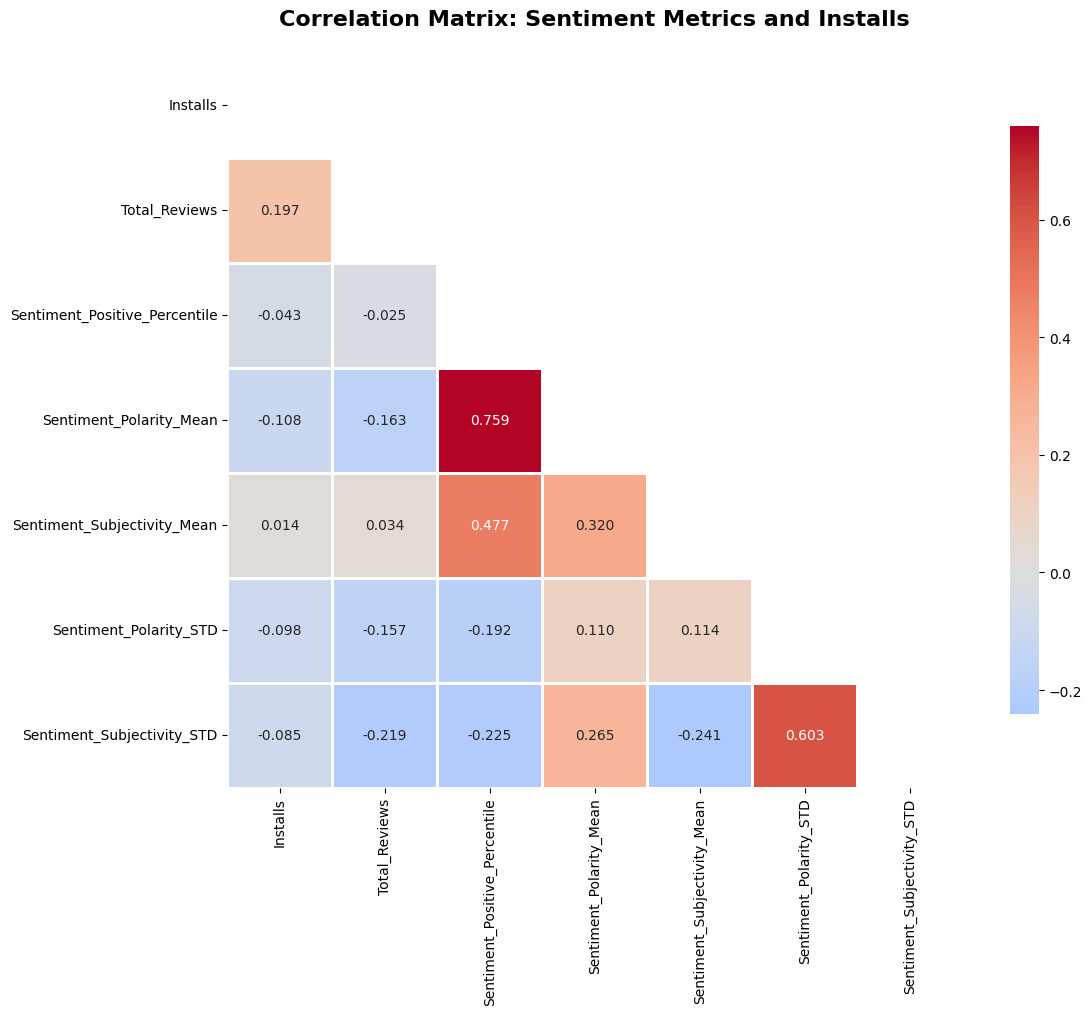

✓ Saved: /content/figs/reviews/installs_vs_sentiment_scatter.png


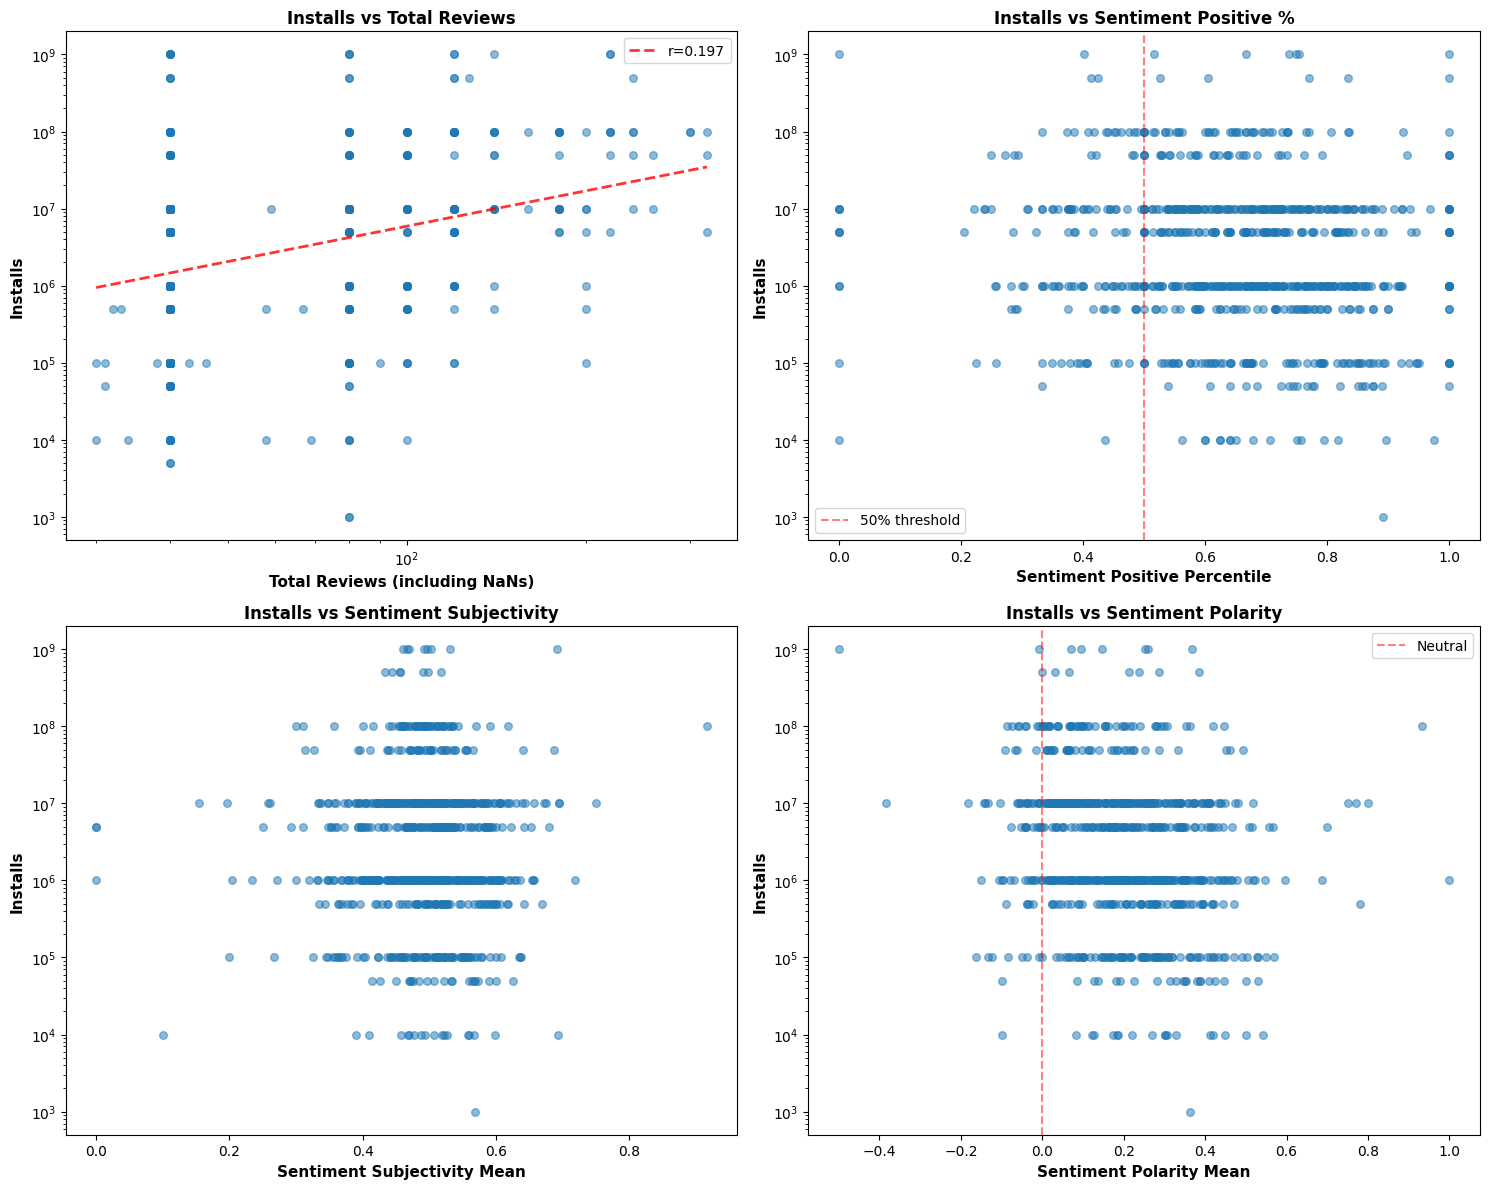

In [46]:
df = load_and_merge_data()
corr_matrix = analyze_correlations(df)

`analyze_objectivity_vs_subjectivity(df)`
Looks at the distribution of average subjectivity scores across apps, summarizing them with basic statistics, a histogram, and a pie chart that splits apps into “more objective” (< 0.5) and “more subjective” (>= 0.5) groups. This helps us understand whether the reviews in this dataset tend to be written in a more factual or opinionated style overall.


In [47]:
def analyze_objectivity_vs_subjectivity(df):
    """Analyze whether comments tend to be more objective or subjective."""
    print("Objectivity vs Subjectivity Analysis")
    subjectivity = df['Sentiment_Subjectivity_Mean'].dropna()
    print(f"\nSubjectivity Statistics:")
    print(f"Mean:{subjectivity.mean():.4f}")
    print(f"Median:{subjectivity.median():.4f}")
    print(f"Std:{subjectivity.std():.4f}")
    print(f"Min:{subjectivity.min():.4f}")
    print(f"Max:{subjectivity.max():.4f}")
    objective_count = (subjectivity < 0.5).sum()
    subjective_count = (subjectivity >= 0.5).sum()


    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Distribution histogram
    ax = axes[0]
    ax.hist(subjectivity, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax.axvline(subjectivity.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {subjectivity.mean():.3f}')
    ax.axvline(subjectivity.median(), color='green', linestyle='--', linewidth=2,
               label=f'Median: {subjectivity.median():.3f}')
    ax.axvline(0.5, color='orange', linestyle='--', linewidth=2,
               label='Objective/Subjective Threshold')
    ax.set_xlabel('Subjectivity Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Apps', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Comment Subjectivity', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    colors = ['#66b3ff', '#ff9999']
    explode = (0.05, 0.05)
    ax.pie([objective_count, subjective_count],
           labels=['More Objective\n(< 0.5)', 'More Subjective\n(≥ 0.5)'],
           autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,
           textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title('Objective vs Subjective Comments', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(FIG_REV / 'objectivity_vs_subjectivity.png', dpi=300, bbox_inches='tight')
    print(f"\n Saved: {FIG_REV / 'objectivity_vs_subjectivity.png'}")
    plt.show()
    plt.close()

Objectivity vs Subjectivity Analysis

Subjectivity Statistics:
Mean:0.4919
Median:0.4971
Std:0.0852
Min:0.0000
Max:0.9167

 Saved: /content/figs/reviews/objectivity_vs_subjectivity.png


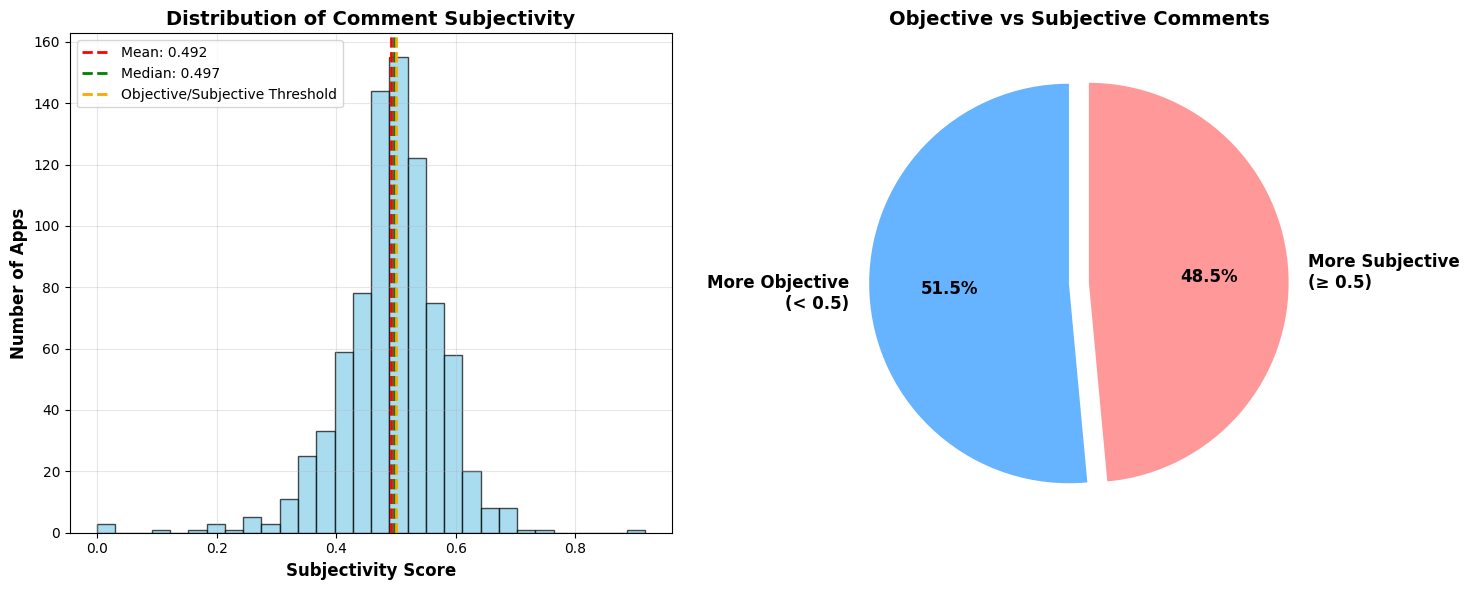

In [48]:
analyze_objectivity_vs_subjectivity(df)

`analyze_subjectivity_by_category(df)`
Examines how subjectivity varies by app category by computing summary statistics per category, plotting mean subjectivity across categories, and visualizing the distributions for the most common categories with box plots.  
An ANOVA test is then used to check whether differences in subjectivity between categories are statistically significant, helping us see if some app categories attract more subjective (or more objective) types of reviews than others.

In [49]:
def analyze_subjectivity_by_category(df):
    """Analyze relationship between subjectivity and app categories."""
    print("Subjectivity by Category Analysis")

    # Calculate mean subjectivity by category
    category_subjectivity = df.groupby('Category').agg({
        'Sentiment_Subjectivity_Mean': ['mean', 'median', 'std', 'count']
    }).round(4)

    category_subjectivity.columns = ['Mean', 'Median', 'Std', 'Count']
    category_subjectivity = category_subjectivity.sort_values('Mean', ascending=False)
    print("\nTop 10 Most Subjective Categories:")
    print(category_subjectivity.head(10).to_string())
    print("\nTop 10 Most Objective Categories:")
    print(category_subjectivity.tail(10).to_string())

    # Filter categories with at least 10 apps for visualization
    categories_filtered = category_subjectivity[category_subjectivity['Count'] >= 10].copy()

    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    # 1. Bar plot of mean subjectivity by category
    ax = axes[0]
    categories_sorted = categories_filtered.sort_values('Mean', ascending=True)
    y_pos = np.arange(len(categories_sorted))

    colors = ['green' if x < 0.5 else 'red' for x in categories_sorted['Mean']]

    ax.barh(y_pos, categories_sorted['Mean'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories_sorted.index, fontsize=9)
    ax.set_xlabel('Mean Subjectivity Score', fontsize=12, fontweight='bold')
    ax.set_title('Mean Comment Subjectivity by Category (≥10 apps)',
                 fontsize=14, fontweight='bold')
    ax.axvline(0.5, color='blue', linestyle='--', linewidth=2, alpha=0.7,
               label='Objective/Subjective Threshold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')

    # 2. Box plot for top categories by count
    ax = axes[1]
    top_categories = category_subjectivity.nlargest(15, 'Count').index

    # Prepare data for box plot
    box_data = []
    box_labels = []
    for cat in top_categories:
        cat_data = df[df['Category'] == cat]['Sentiment_Subjectivity_Mean'].dropna()
        if len(cat_data) > 0:
            box_data.append(cat_data)
            box_labels.append(f"{cat}\n(n={len(cat_data)})")

    bp = ax.boxplot(box_data, tick_labels=box_labels, patch_artist=True, vert=True)

    # Color boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    ax.axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7,
               label='Objective/Subjective Threshold')
    ax.set_ylabel('Subjectivity Score', fontsize=12, fontweight='bold')
    ax.set_xlabel('Category', fontsize=12, fontweight='bold')
    ax.set_title('Subjectivity Distribution for Top 15 Categories by App Count',
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right', fontsize=9)

    plt.tight_layout()
    plt.savefig(FIG_REV / 'subjectivity_by_category.png', dpi=300, bbox_inches='tight')
    print(f"\n Saved: {FIG_REV / 'subjectivity_by_category.png'}")
    plt.show()
    plt.close()

    category_groups = []
    for cat in top_categories:
        cat_data = df[df['Category'] == cat]['Sentiment_Subjectivity_Mean'].dropna()
        if len(cat_data) >= 5:  # At least 5 samples
            category_groups.append(cat_data.values)

    if len(category_groups) >= 2:
        f_stat, p_value = stats.f_oneway(*category_groups)
        print(f"\nANOVA Test (top categories):")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  P-value:     {p_value:.6f}")
        if p_value < 0.05:
            print("Categories differ SIGNIFICANTLY in subjectivity (p < 0.05)")
        else:
            print("No significant difference between categories (p >= 0.05)")

    return category_subjectivity

Subjectivity by Category Analysis

Top 10 Most Subjective Categories:
                      Mean  Median     Std  Count
Category                                         
EVENTS              0.5819  0.5702  0.0541      5
ART_AND_DESIGN      0.5385  0.5360  0.0623      9
LIBRARIES_AND_DEMO  0.5256  0.5381  0.0876      9
AUTO_AND_VEHICLES   0.5230  0.5300  0.0321      8
FOOD_AND_DRINK      0.5214  0.5137  0.0705     18
PERSONALIZATION     0.5214  0.5196  0.0731     34
HEALTH_AND_FITNESS  0.5213  0.5219  0.0649     40
FAMILY              0.5098  0.5073  0.0593     69
PARENTING           0.5033  0.5017  0.0755      8
DATING              0.5007  0.5087  0.0987     33

Top 10 Most Objective Categories:
                       Mean  Median     Std  Count
Category                                          
VIDEO_PLAYERS        0.4787  0.4494  0.0547      9
TRAVEL_AND_LOCAL     0.4784  0.4807  0.1189     42
LIFESTYLE            0.4770  0.4996  0.0988     23
SHOPPING             0.4762  0.4750  0.0

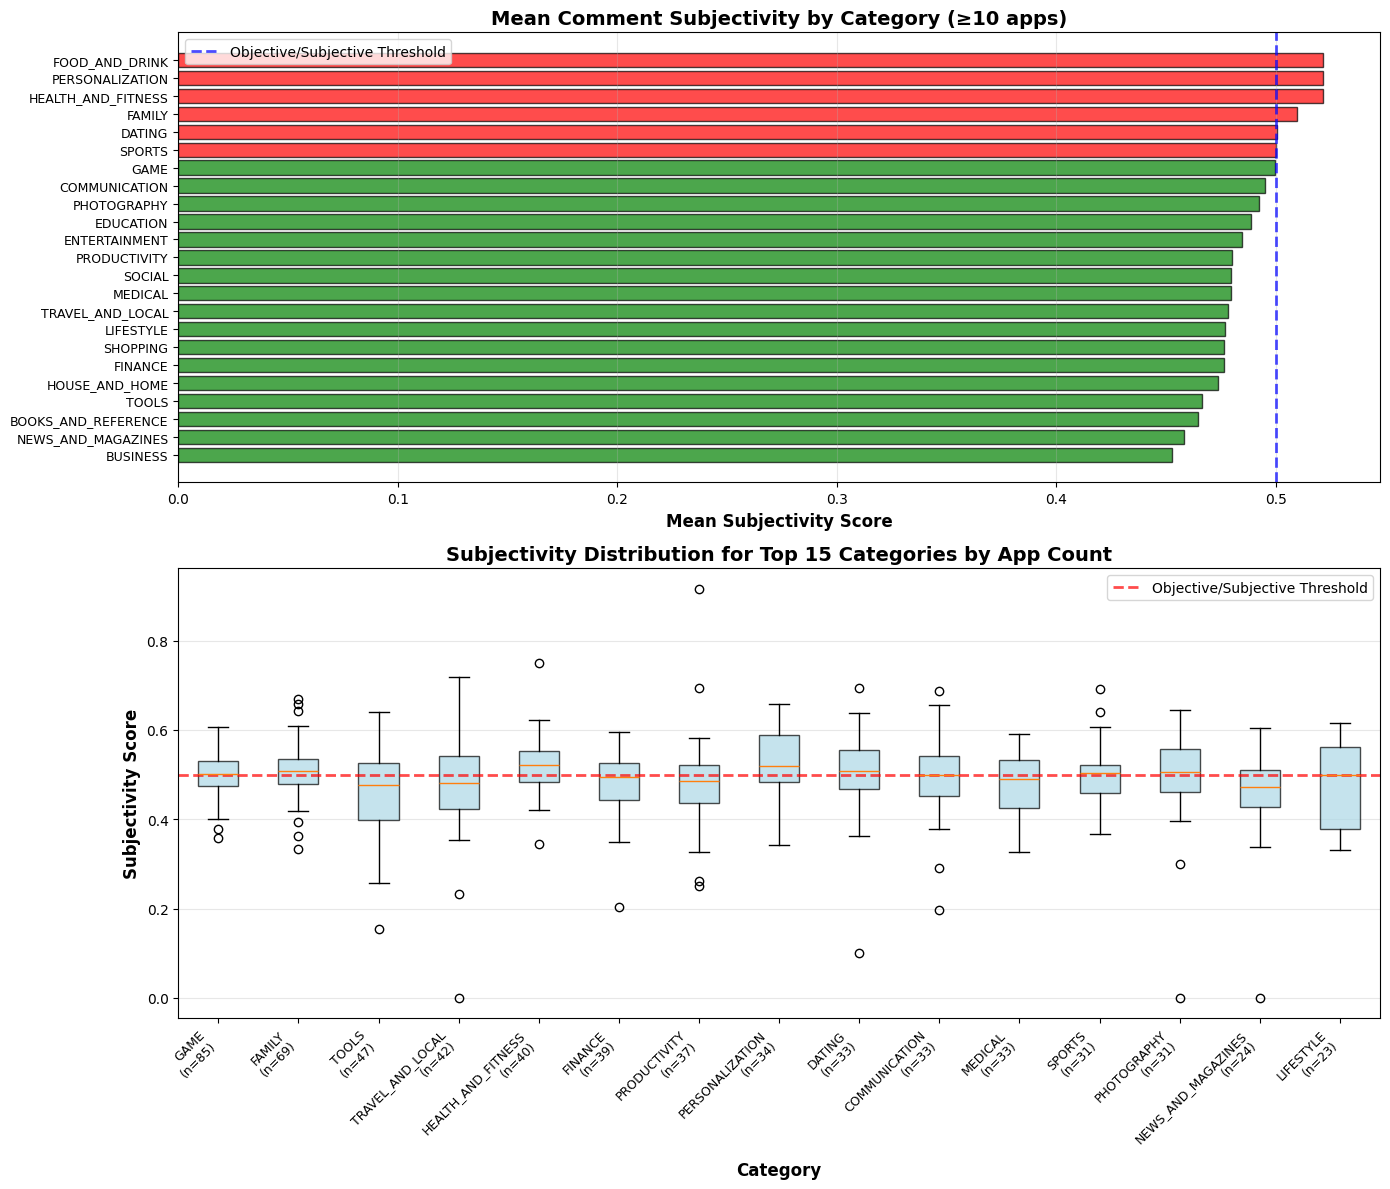


ANOVA Test (top categories):
  F-statistic: 1.7828
  P-value:     0.037737
Categories differ SIGNIFICANTLY in subjectivity (p < 0.05)


In [50]:
category_subjectivity = analyze_subjectivity_by_category(df)

# Main Apps Analysis

### Install Behavior Analysis Overview
This section explores how app installs relate to different characteristics such as update timing, Android version, developer activity, reviews, pricing, and category differences. The boxplot of installs by last updated month shows whether more recently updated apps tend to receive more downloads, while the Android version boxplot checks whether support for newer or older Android versions correlates with popularity. The heatmap combining update recency and Android version highlights how these two factors interact to influence installs. The correlation heatmap summarizes how installs relate to key numeric features, reinforcing that only a few variables (like review count) have meaningful associations. The scatter plots of installs vs. reviews—shown on both log and linear scales—illustrate the strong growth trend between visibility and installs, while the scatter against price shows how pricing impacts downloads. Finally, the category-level boxplot compares the distribution of installs across app categories, revealing which categories tend to dominate in overall popularity. Together, these visualizations provide a broad picture of what factors influence install performance across the Play Store dataset.


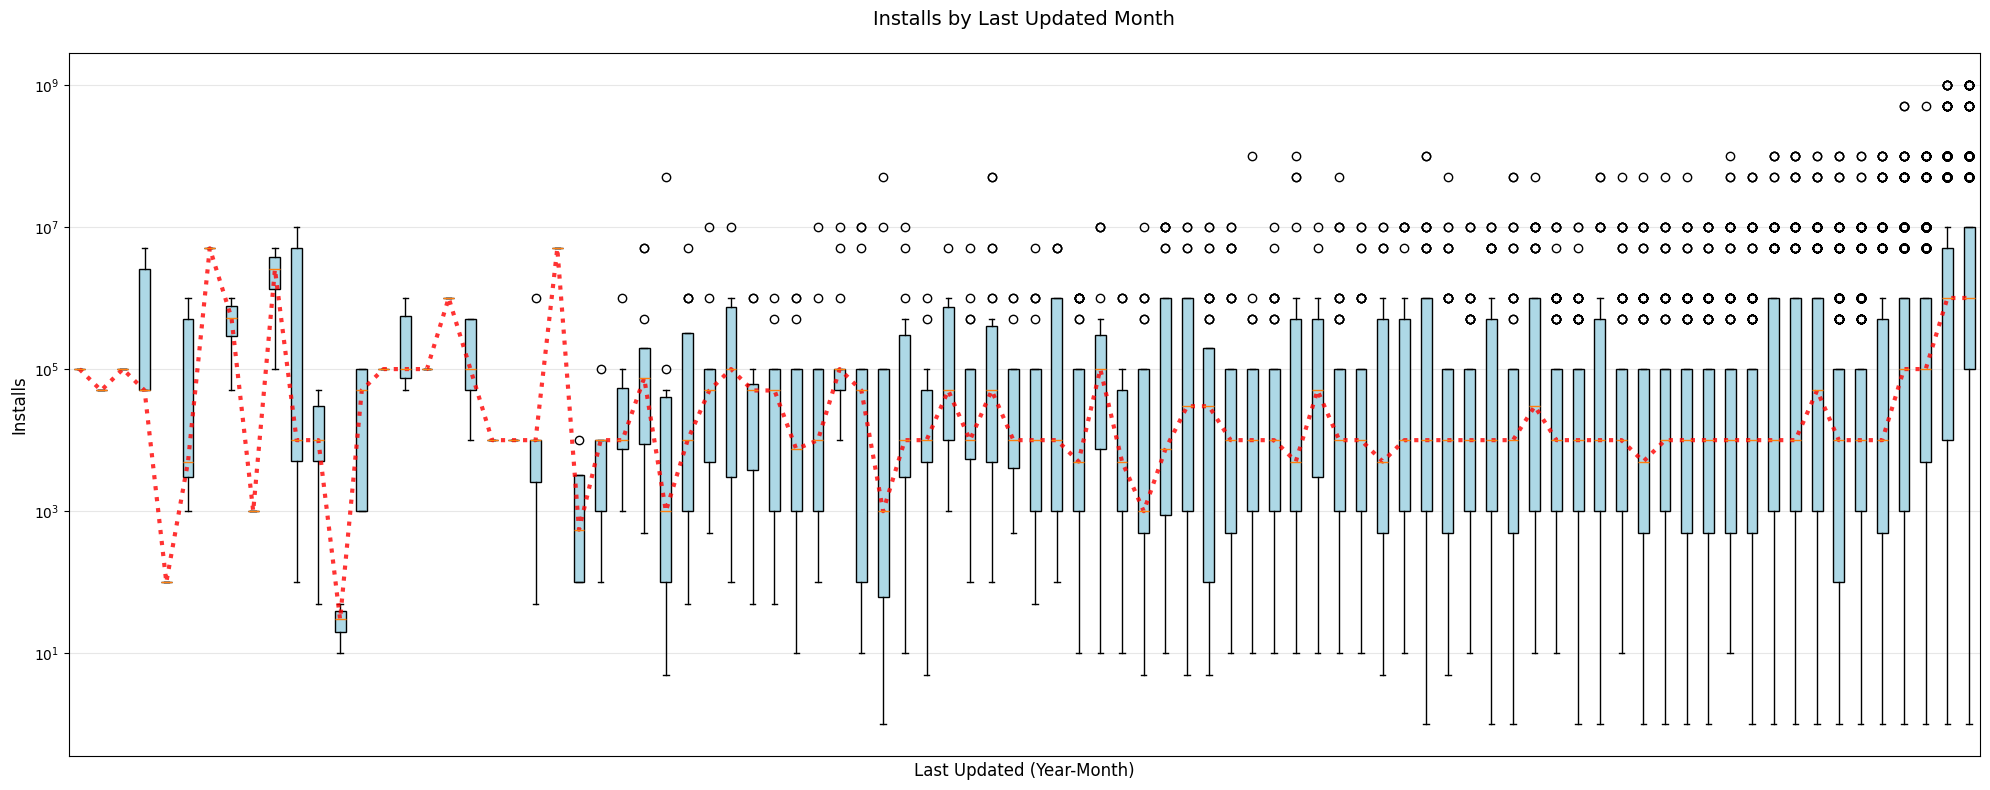

Box plot saved to: /content/figs/apps/installs_by_last_updated.png


In [51]:
def plot_installs_by_last_updated(
    csv_input_path: Union[str, Path] = OUT_APPS,
    output_figure_dir: Union[str, Path] = FIG_APPS,
) -> None:
    """Plot box plot of Installs by Last Updated month."""

    csv_file = Path(csv_input_path)
    output_path = Path(output_figure_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Installs", "Last Updated"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset["Last Updated"] = pd.to_datetime(df_subset["Last Updated"], errors="coerce")
    df_subset = df_subset.dropna()
    df_subset = df_subset[df_subset["Installs"] > 0]

    df_subset["YearMonth"] = df_subset["Last Updated"].dt.to_period("M")
    df_subset = df_subset.sort_values("YearMonth")

    plt.figure(figsize=(20, 8))
    unique_months = df_subset["YearMonth"].unique()
    data_by_month = [df_subset[df_subset["YearMonth"] == month]["Installs"].values for month in unique_months]

    bp = plt.boxplot(data_by_month, patch_artist=True)
    for patch in bp["boxes"]:
        patch.set_facecolor("lightblue")

    medians = [np.median(data) for data in data_by_month]
    x_positions = range(1, len(medians) + 1)
    plt.plot(x_positions, medians, 'r:', linewidth=3, alpha=0.8)

    plt.xlabel("Last Updated (Year-Month)", fontsize=12)
    plt.ylabel("Installs", fontsize=12)
    plt.title("Installs by Last Updated Month", fontsize=14, pad=20)
    plt.xticks([])
    plt.yscale("log")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_by_last_updated.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    print(f"Box plot saved to: {output_file}")

plot_installs_by_last_updated(csv_input_path=OUT_APPS, output_figure_dir=FIG_APPS)

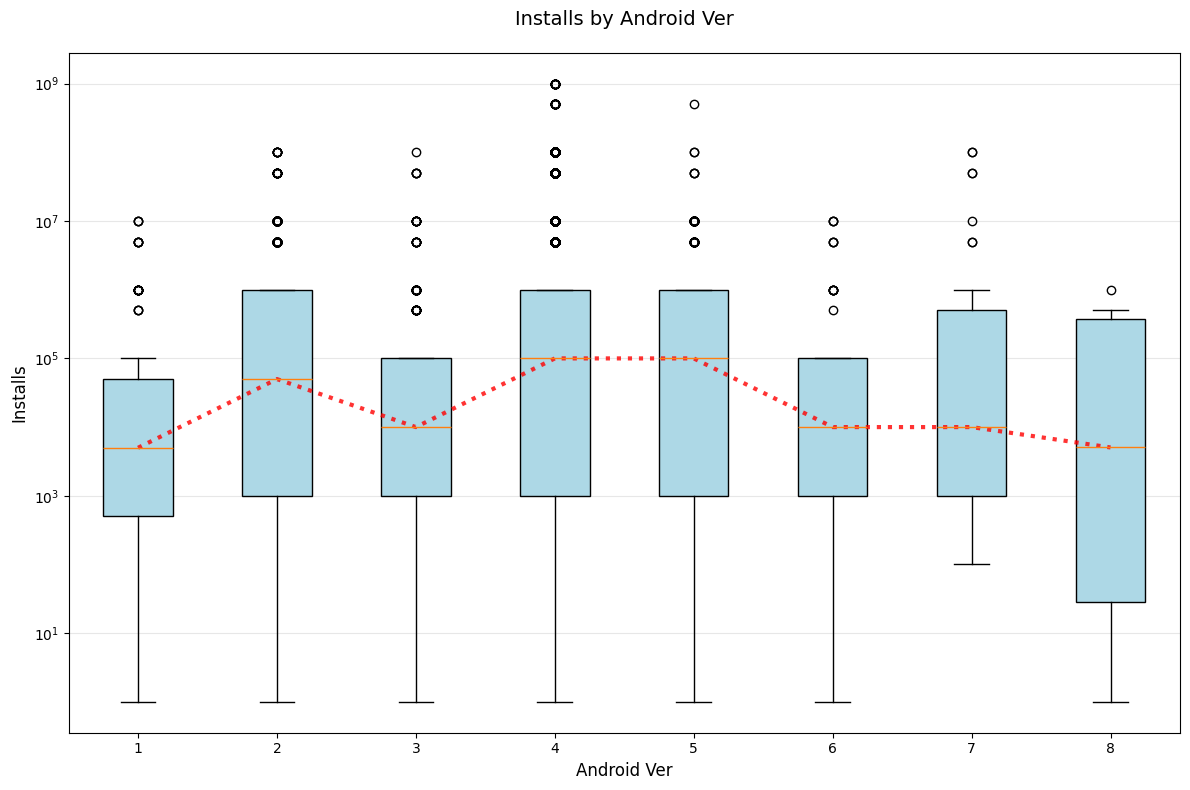

Box plot saved to: /content/figs/apps/installs_by_android_ver.png


In [52]:
def plot_installs_by_android_ver(
    root: Optional[Path] = None,
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS,
) -> None:
    """Plot box plot of Installs by Android Ver."""
    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Installs", "Android Ver"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset["Android Ver"] = pd.to_numeric(df_subset["Android Ver"], errors="coerce")
    df_subset = df_subset.dropna()
    df_subset = df_subset[df_subset["Installs"] > 0]

    android_vers = sorted(df_subset["Android Ver"].unique())
    data_by_ver = [df_subset[df_subset["Android Ver"] == ver]["Installs"].values for ver in android_vers]

    plt.figure(figsize=(12, 8))
    bp = plt.boxplot(data_by_ver, tick_labels=[str(int(ver)) for ver in android_vers], patch_artist=True)
    for patch in bp["boxes"]:
        patch.set_facecolor("lightblue")

    medians = [np.median(data) for data in data_by_ver]
    x_positions = range(1, len(medians) + 1)
    plt.plot(x_positions, medians, 'r:', linewidth=3, alpha=0.8)

    plt.xlabel("Android Ver", fontsize=12)
    plt.ylabel("Installs", fontsize=12)
    plt.title("Installs by Android Ver", fontsize=14, pad=20)
    plt.yscale("log")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_by_android_ver.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    print(f"Box plot saved to: {output_file}")
plot_installs_by_android_ver(csv_path=OUT_APPS, output_dir=FIG_APPS)

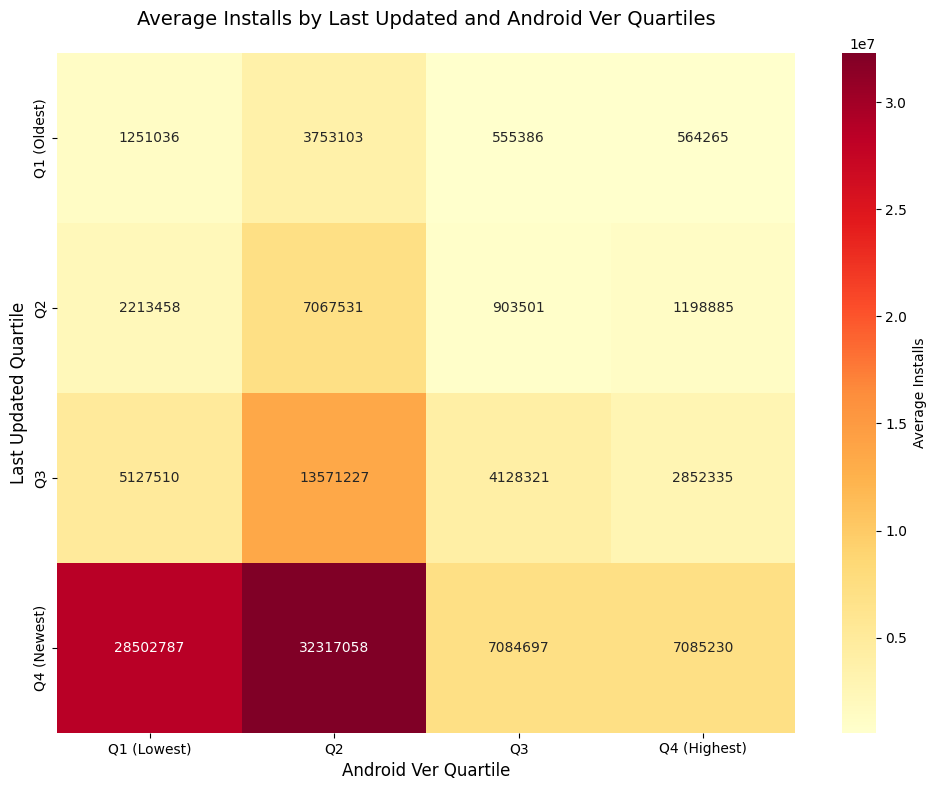

Heatmap saved to: /content/figs/apps/installs_heatmap_by_activity.png


In [53]:
def plot_installs_heatmap_by_activity(
    root: Optional[Path] = None,
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS,
) -> None:
    """Plot 2D heatmap of average Installs by Last Updated and Android Ver quartiles."""
    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Installs", "Last Updated", "Android Ver"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset["Last Updated"] = pd.to_datetime(df_subset["Last Updated"], errors="coerce")
    df_subset["Android Ver"] = pd.to_numeric(df_subset["Android Ver"], errors="coerce")
    df_subset = df_subset.dropna()
    df_subset = df_subset[df_subset["Installs"] > 0]

    df_subset["LastUpdated_quartile"] = pd.qcut(df_subset["Last Updated"].rank(method="first"), q=4, labels=["Q1 (Oldest)", "Q2", "Q3", "Q4 (Newest)"])
    df_subset["AndroidVer_quartile"] = pd.qcut(df_subset["Android Ver"].rank(method="first"), q=4, labels=["Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"])

    heatmap_data = df_subset.groupby(["LastUpdated_quartile", "AndroidVer_quartile"], observed=True)["Installs"].mean().unstack()

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={"label": "Average Installs"})
    plt.xlabel("Android Ver Quartile", fontsize=12)
    plt.ylabel("Last Updated Quartile", fontsize=12)
    plt.title("Average Installs by Last Updated and Android Ver Quartiles", fontsize=14, pad=20)
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_heatmap_by_activity.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    print(f"Heatmap saved to: {output_file}")

plot_installs_heatmap_by_activity(csv_path=OUT_APPS, output_dir=FIG_APPS)

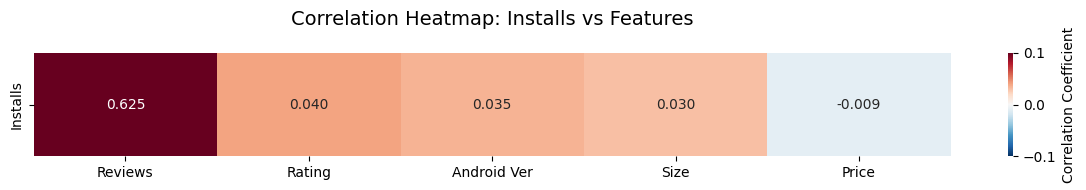

Heatmap saved to: /content/figs/apps/installs_correlations_heatmap.png

Correlation values with Installs:
Reviews                0.625058
Rating                 0.040245
Android_Ver_encoded    0.034992
Size                   0.030450
Price                 -0.009410


In [54]:
def plot_installs_correlations_heatmap(
    root: Optional[Path] = None,
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS,
) -> None:
    """Plot correlation heatmap between Installs and features."""
    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Rating", "Reviews", "Price", "Size", "Android Ver", "Installs"]].copy()

    df_subset["Android_Ver_encoded"] = pd.Categorical(df_subset["Android Ver"]).codes
    df_subset["Android_Ver_encoded"] = df_subset["Android_Ver_encoded"].replace(-1, np.nan)

    corr_columns = ["Rating", "Reviews", "Price", "Size", "Android_Ver_encoded", "Installs"]
    df_corr = df_subset[corr_columns].copy()

    for col in df_corr.columns:
        df_corr[col] = pd.to_numeric(df_corr[col], errors="coerce")

    corr_matrix = df_corr.corr()
    installs_corr = corr_matrix["Installs"].drop("Installs").sort_values(ascending=False)

    name_mapping = {
        "Android_Ver_encoded": "Android Ver"
    }
    feature_names = [name_mapping.get(name, name) for name in installs_corr.index.tolist()]

    heatmap_data = installs_corr.values.reshape(1, -1)

    vmin, vmax = -0.1, 0.1

    plt.figure(figsize=(12, 2))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        cmap="RdBu_r",
        center=0,
        vmin=vmin,
        vmax=vmax,
        xticklabels=feature_names,
        yticklabels=["Installs"],
        cbar_kws={"label": "Correlation Coefficient"}
    )
    plt.title("Correlation Heatmap: Installs vs Features", fontsize=14, pad=20)
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_correlations_heatmap.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    print(f"Heatmap saved to: {output_file}")
    print("\nCorrelation values with Installs:")
    print(installs_corr.to_string())
plot_installs_correlations_heatmap()

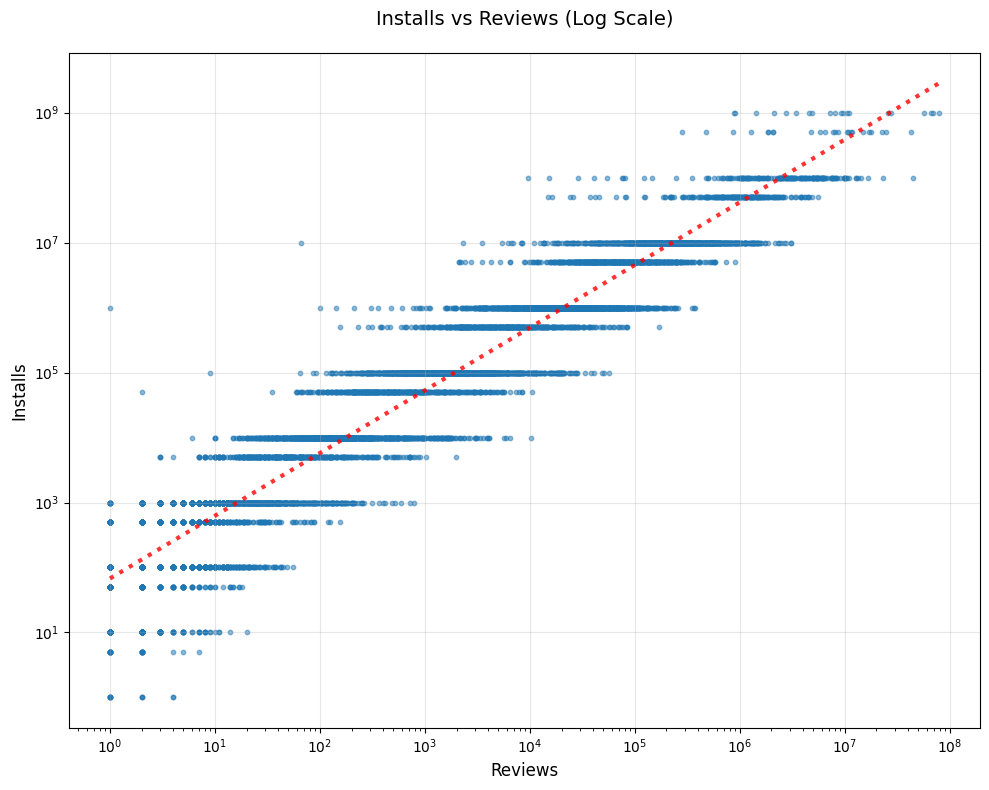

Scatter plot saved to: /content/figs/apps/installs_vs_reviews_scatter_log.png


In [55]:
def plot_installs_vs_reviews_scatter(
    root: Optional[Path] = None,
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS
) -> None:
    """Plot scatter plot of Installs vs Reviews with log scales."""
    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Installs", "Reviews"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset["Reviews"] = pd.to_numeric(df_subset["Reviews"], errors="coerce")
    df_subset = df_subset.dropna()
    df_subset = df_subset[(df_subset["Installs"] > 0) & (df_subset["Reviews"] > 0)]

    log_reviews = np.log10(df_subset["Reviews"])
    log_installs = np.log10(df_subset["Installs"])

    slope, intercept = np.polyfit(log_reviews, log_installs, 1)

    x_line = np.logspace(log_reviews.min(), log_reviews.max(), 100)
    y_line = 10**(slope * np.log10(x_line) + intercept)

    plt.figure(figsize=(10, 8))
    plt.scatter(df_subset["Reviews"], df_subset["Installs"], alpha=0.5, s=10)
    plt.plot(x_line, y_line, 'r:', linewidth=3, alpha=0.8)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Reviews", fontsize=12)
    plt.ylabel("Installs", fontsize=12)
    plt.title("Installs vs Reviews (Log Scale)", fontsize=14, pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_vs_reviews_scatter_log.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    print(f"Scatter plot saved to: {output_file}")
plot_installs_vs_reviews_scatter()

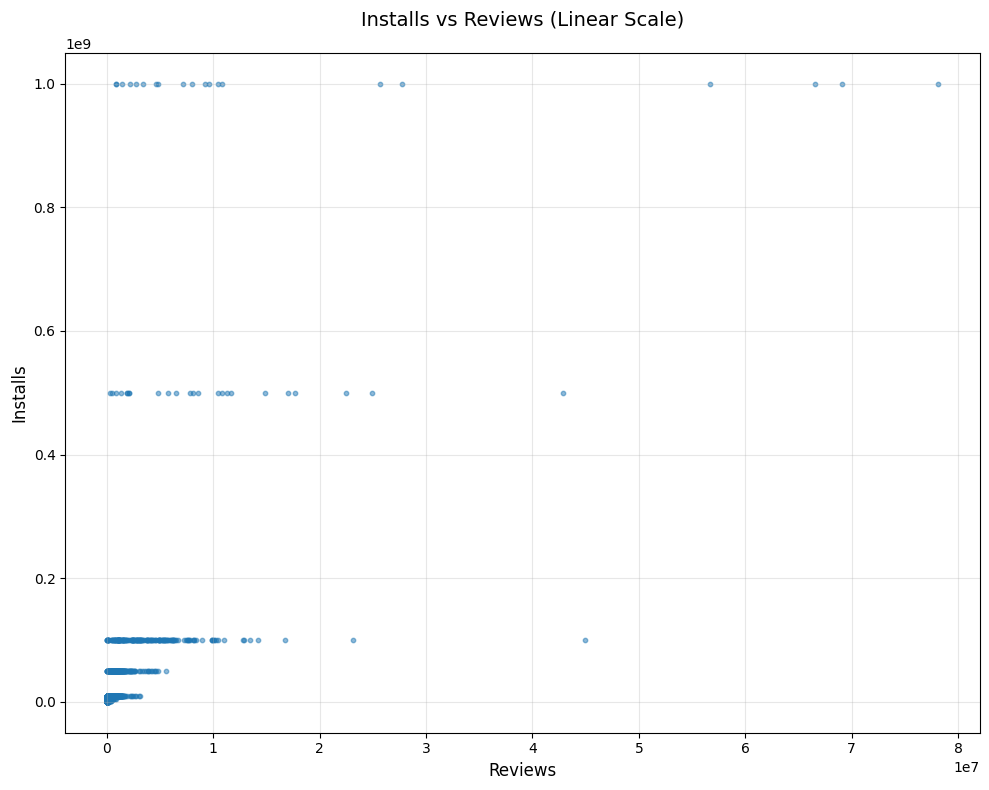

Scatter plot (linear) saved to: /content/figs/apps/installs_vs_reviews_scatter_linear.png


In [56]:
def plot_installs_vs_reviews_scatter_linear(
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS
) -> None:
    """Plot scatter plot of Installs vs Reviews with linear scales."""

    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Installs", "Reviews"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset["Reviews"] = pd.to_numeric(df_subset["Reviews"], errors="coerce")
    df_subset = df_subset.dropna()

    plt.figure(figsize=(10, 8))
    plt.scatter(df_subset["Reviews"], df_subset["Installs"], alpha=0.5, s=10)
    plt.xlabel("Reviews", fontsize=12)
    plt.ylabel("Installs", fontsize=12)
    plt.title("Installs vs Reviews (Linear Scale)", fontsize=14, pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_vs_reviews_scatter_linear.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show() # Added plt.show()
    plt.close()

    print(f"Scatter plot (linear) saved to: {output_file}")
plot_installs_vs_reviews_scatter_linear()

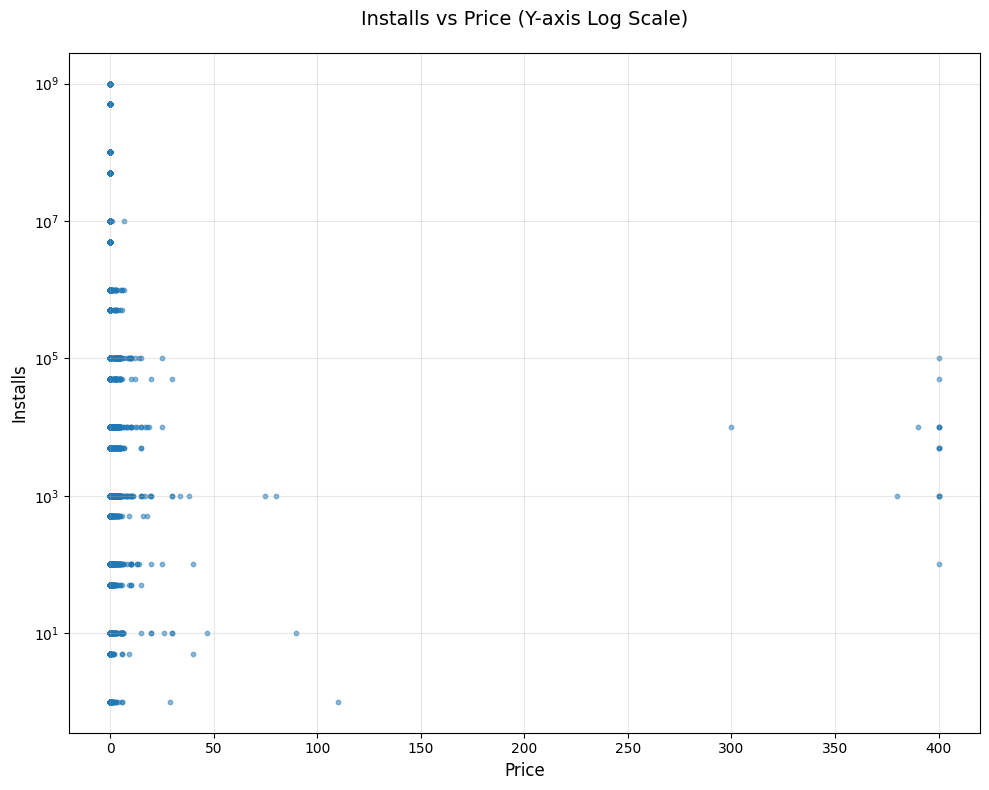

Scatter plot saved to: /content/figs/apps/installs_vs_price_scatter_log.png


In [57]:
def plot_installs_vs_price_scatter(
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS
) -> None:
    """Plot scatter plot of Installs vs Price with y-axis log scale."""

    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Installs", "Price"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset["Price"] = pd.to_numeric(df_subset["Price"], errors="coerce")
    df_subset = df_subset.dropna()
    df_subset = df_subset[df_subset["Installs"] > 0]

    plt.figure(figsize=(10, 8))
    plt.scatter(df_subset["Price"], df_subset["Installs"], alpha=0.5, s=10)
    plt.yscale("log")
    plt.xlabel("Price", fontsize=12)
    plt.ylabel("Installs", fontsize=12)
    plt.title("Installs vs Price (Y-axis Log Scale)", fontsize=14, pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_vs_price_scatter_log.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show() # Added plt.show()
    plt.close()

    print(f"Scatter plot saved to: {output_file}")
plot_installs_vs_price_scatter()

/tmp/ipython-input-89287067.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlOrRd")
/tmp/ipython-input-89287067.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_by_category, labels=categories, patch_artist=True)


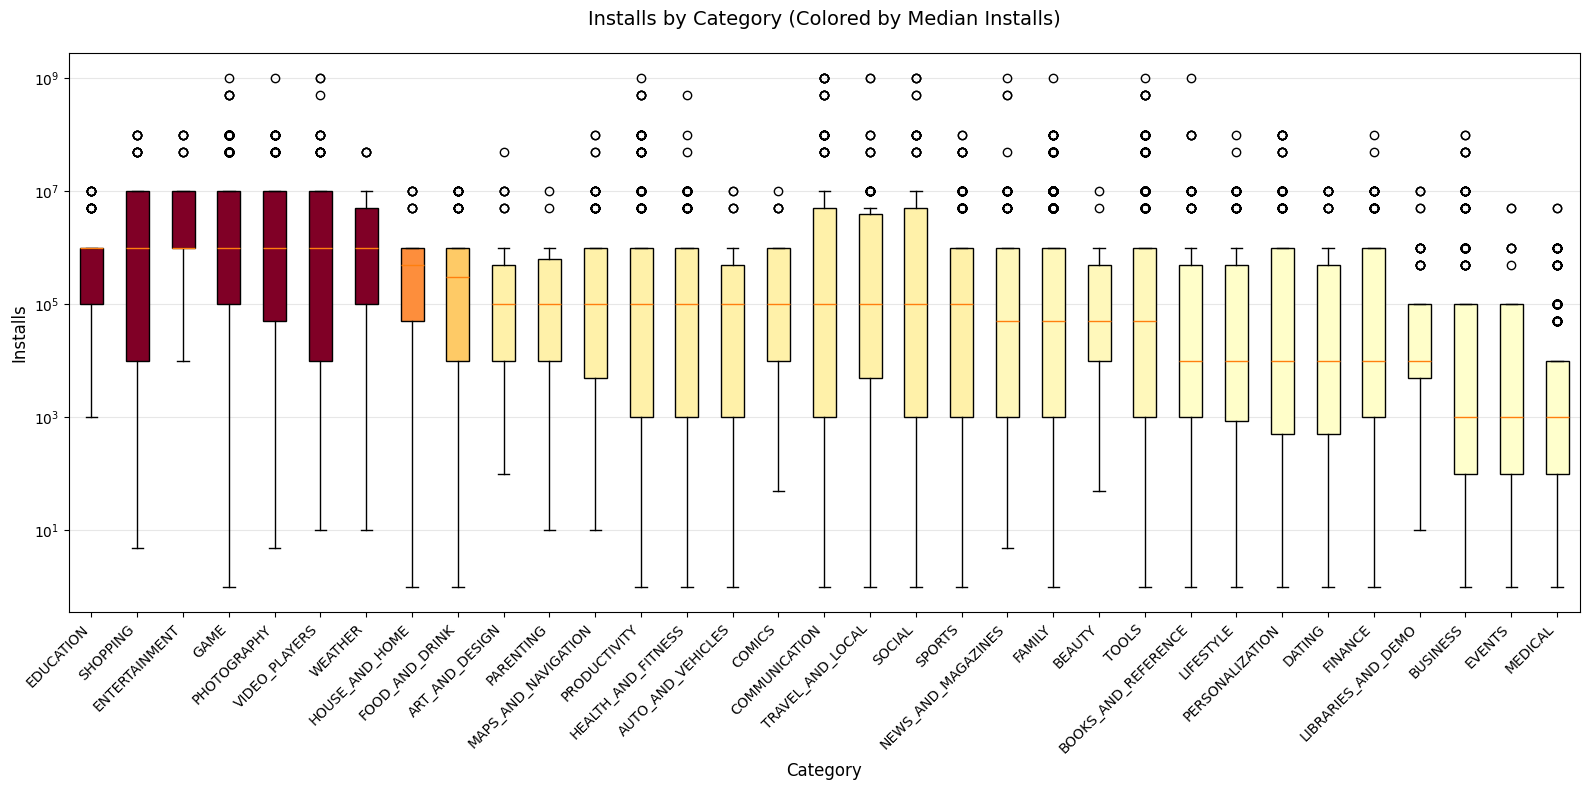

Box plot saved to: /content/figs/apps/installs_by_category_boxplot.png


In [58]:
def plot_installs_by_category_boxplot(
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS
) -> None:
    """Plot box plot of Installs by Category."""

    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Category", "Installs"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset = df_subset.dropna()
    df_subset = df_subset[df_subset["Installs"] > 0]

    median_installs = df_subset.groupby("Category")["Installs"].median().sort_values(ascending=False)
    categories = median_installs.index.tolist()

    norm = plt.Normalize(vmin=median_installs.min(), vmax=median_installs.max())
    cmap = plt.cm.get_cmap("YlOrRd")

    data_by_category = [df_subset[df_subset["Category"] == cat]["Installs"].values for cat in categories]
    colors = [cmap(norm(median_installs[cat])) for cat in categories]

    plt.figure(figsize=(16, 8))
    bp = plt.boxplot(data_by_category, labels=categories, patch_artist=True)

    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)

    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Installs", fontsize=12)
    plt.title("Installs by Category (Colored by Median Installs)", fontsize=14, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yscale("log")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_by_category_boxplot.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show() # Added plt.show()
    plt.close()

    print(f"Box plot saved to: {output_file}")
plot_installs_by_category_boxplot()

### Pricing, Type, Rating, Size, and Content Rating Analysis
This section looks at how installs relate to price, app type, rating, size, and content rating. The `print_apps_price_over_200` function shows the very high-priced apps (price > $200) and gives the top 5 in a table. `plot_avg_installs_by_type` compares average installs between Free and Paid apps, giving a quick view of how strongly the free–paid choice is more popular compared to paid. `plot_installs_vs_rating` aggregates installs into fine 0.1 rating bands to show how downloads concentrate around particular rating levels, revealing whether higher-rated apps really dominate install volumes. `plot_installs_vs_size_by_category` visualizes installs versus app size, colored by the top categories, so we can see whether heavier apps are penalized in terms of downloads and whether this varies by category. Finally, `create_viz_for_content_rating` explores the content rating dimension in three ways: overall counts per rating, how categories are distributed inside each content rating, and how installs differ by rating and by the top categories within each rating. Together, these plots and tables give a broad picture of how commercial choices (price, free vs paid), quality signals (rating), technical traits (size), and audience targeting (content rating) shape app visibility and adoption.

Apps with price > 200 (17 apps):

                              App  Category  Rating Reviews      Size  Installs Type  Price Content Rating        Genres      Last Updated Current Ver  Android Ver
         I'm Rich - Trump Edition LIFESTYLE     3.6     275  7.300000   10000.0 Paid 400.00       Everyone     Lifestyle       May 3, 2018       1.0.1            4
           most expensive app (H)    FAMILY     4.3       6  1.500000     100.0 Paid 399.99       Everyone Entertainment     July 16, 2018         1.0            7
                       💎 I'm rich LIFESTYLE     3.8     718 26.000000   10000.0 Paid 399.99       Everyone     Lifestyle    March 11, 2018       1.0.0            4
                        I am rich LIFESTYLE     3.8    3547  1.800000  100000.0 Paid 399.99       Everyone     Lifestyle  January 12, 2018         2.0            4
                   I am Rich Plus    FAMILY     4.0     856  8.700000   10000.0 Paid 399.99       Everyone Entertainment      May 19, 2018        

/tmp/ipython-input-2976599675.py:45: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_file, bbox_inches="tight", dpi=300)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


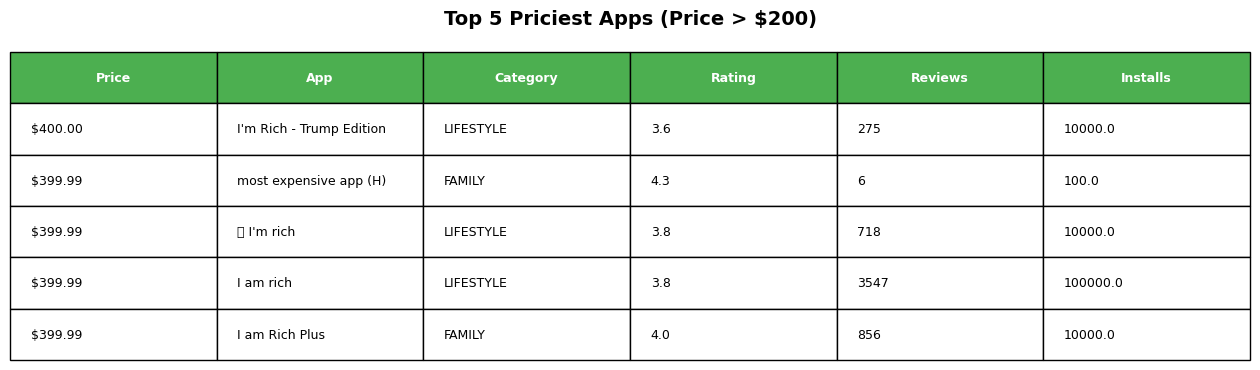


Image saved to: /content/figs/apps/top5_priciest_apps.png


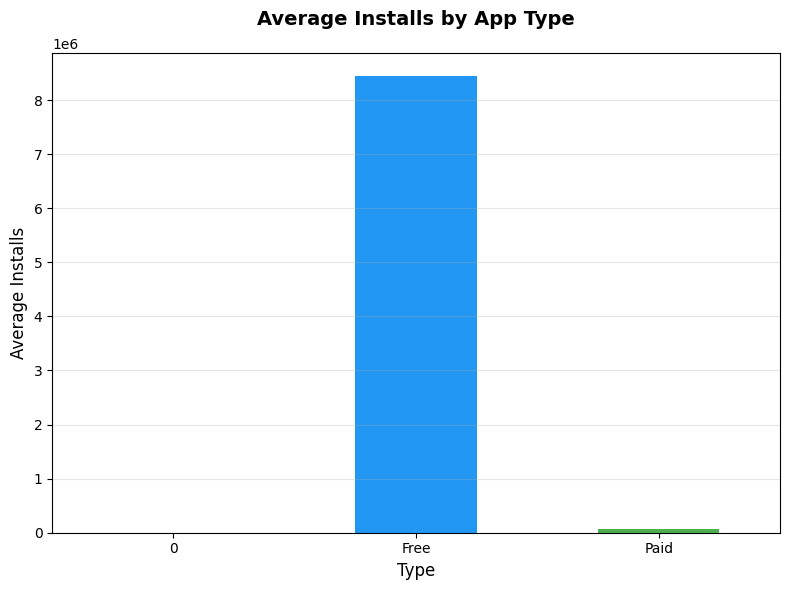

Bar graph saved to: /content/figs/apps/avg_installs_by_type.png


In [59]:
def print_apps_price_over_200(
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS
) -> None:
    """Print apps with price > 200."""

    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
    high_price_apps = df[df["Price"] > 200].sort_values("Price", ascending=False)

    if len(high_price_apps) > 0:
        print(f"Apps with price > 200 ({len(high_price_apps)} apps):\n")
        print(high_price_apps.to_string(index=False))

        top5 = high_price_apps.head(5)[["Price", "App", "Category", "Rating", "Reviews", "Installs"]].copy()
        top5["Price"] = top5["Price"].apply(lambda x: f"${x:.2f}")

        fig, ax = plt.subplots(figsize=(16, 4))
        ax.axis("tight")
        ax.axis("off")

        table = ax.table(
            cellText=top5.values,
            colLabels=top5.columns,
            cellLoc="left",
            loc="center",
            bbox=[0, 0, 1, 1]
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)

        for i in range(len(top5.columns)):
            table[(0, i)].set_facecolor("#4CAF50")
            table[(0, i)].set_text_props(weight="bold", color="white")

        plt.title("Top 5 Priciest Apps (Price > $200)", fontsize=14, pad=20, weight="bold")

        output_path.mkdir(parents=True, exist_ok=True)
        output_file = output_path / "top5_priciest_apps.png"
        plt.savefig(output_file, bbox_inches="tight", dpi=300)
        plt.show() # Added plt.show()
        plt.close()

        print(f"\nImage saved to: {output_file}")
    else:
        print("No apps found with price > 200")


def plot_avg_installs_by_type(
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS
) -> None:
    """Plot bar graph of average installs by Type."""

    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")
    avg_installs = df.groupby("Type")["Installs"].mean()

    plt.figure(figsize=(8, 6))
    avg_installs.plot(kind="bar", color=["#4CAF50", "#2196F3"])
    plt.xlabel("Type", fontsize=12)
    plt.ylabel("Average Installs", fontsize=12)
    plt.title("Average Installs by App Type", fontsize=14, pad=20, weight="bold")
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "avg_installs_by_type.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show() # Added plt.show()
    plt.close()

    print(f"Bar graph saved to: {output_file}")

print_apps_price_over_200()
plot_avg_installs_by_type()

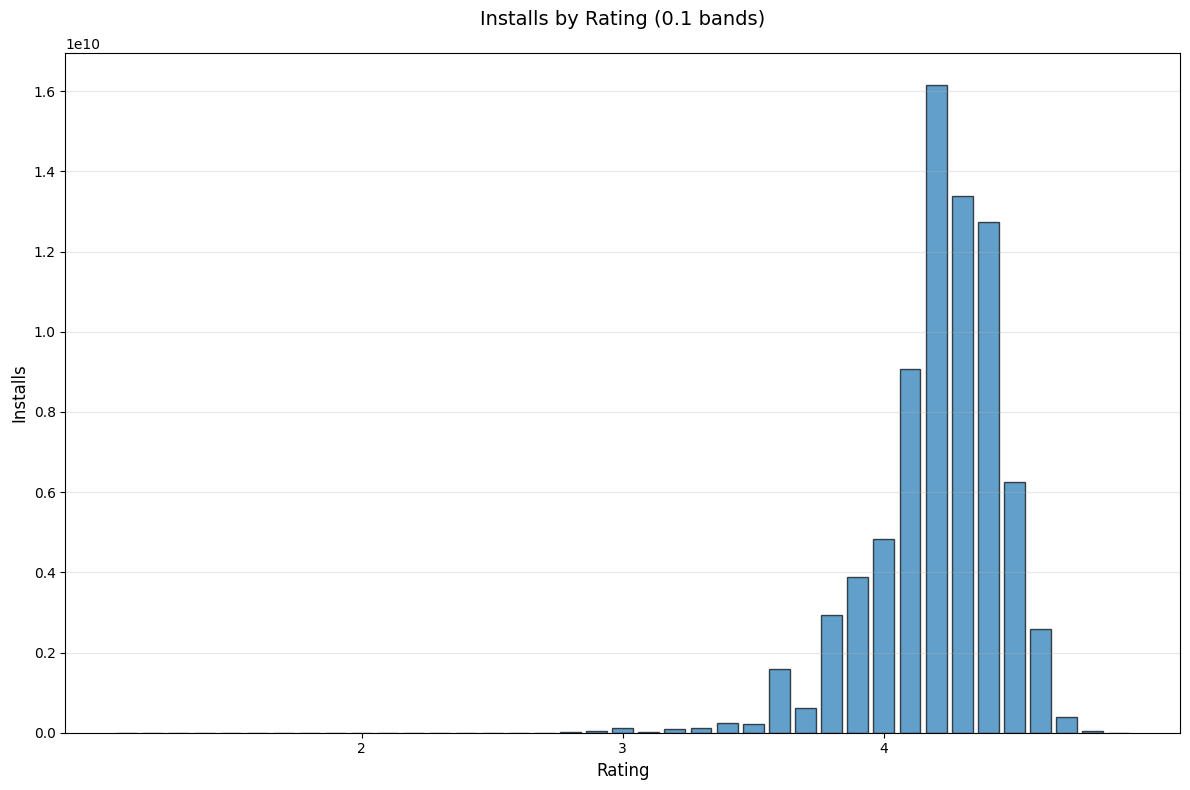

Histogram saved to: /content/figs/apps/installs_vs_rating.png


In [60]:
def plot_installs_vs_rating(
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS
) -> None:
    """Plot histogram of Installs vs Rating with 0.1 bands."""

    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Installs", "Rating"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset["Rating"] = pd.to_numeric(df_subset["Rating"], errors="coerce")
    df_subset = df_subset.dropna()
    df_subset = df_subset[df_subset["Installs"] > 0]

    bins = np.arange(0, 5.1, 0.1)
    df_subset["Rating_band"] = pd.cut(df_subset["Rating"], bins=bins, include_lowest=True)
    installs_by_band = df_subset.groupby("Rating_band", observed=True)["Installs"].sum()

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(installs_by_band)), installs_by_band.values, edgecolor="black", alpha=0.7, width=0.8)
    plt.xlabel("Rating", fontsize=12)
    plt.ylabel("Installs", fontsize=12)
    plt.title("Installs by Rating (0.1 bands)", fontsize=14, pad=20)

    rating_positions = []
    rating_labels = []
    for rating in [1, 2, 3, 4, 5]:
        for i, interval in enumerate(installs_by_band.index):
            if interval.left <= rating < interval.right or (rating == 5.0 and interval.right == 5.1):
                rating_positions.append(i)
                rating_labels.append(str(rating))
                break

    plt.xticks(rating_positions, rating_labels)
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_vs_rating.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show() # Added plt.show()
    plt.close()

    print(f"Histogram saved to: {output_file}")

plot_installs_vs_rating()

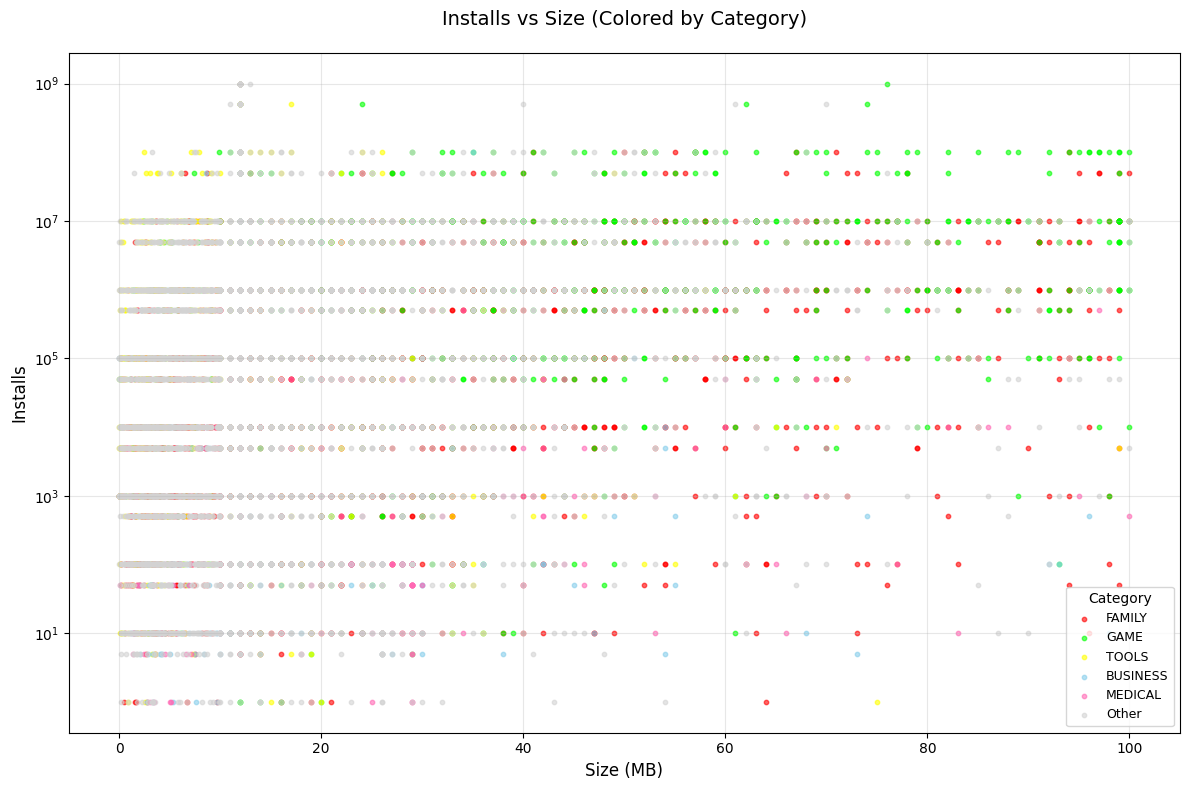

Scatter plot saved to: /content/figs/apps/installs_vs_size_by_category.png


In [61]:
def plot_installs_vs_size_by_category(
    csv_path: str = OUT_APPS,
    output_dir: str = FIG_APPS
) -> None:
    """Plot scatter plot of Installs vs Size colored by Category."""

    csv_file = Path(csv_path)
    output_path = Path(output_dir)

    df = pd.read_csv(csv_file)

    df_subset = df[["Installs", "Size", "Category"]].copy()
    df_subset["Installs"] = pd.to_numeric(df_subset["Installs"], errors="coerce")
    df_subset["Size"] = pd.to_numeric(df_subset["Size"], errors="coerce")
    df_subset = df_subset.dropna()
    df_subset = df_subset[df_subset["Installs"] > 0]

    top5_categories = df_subset["Category"].value_counts().head(5).index.tolist()
    df_subset["Category_group"] = df_subset["Category"].apply(
        lambda x: x if x in top5_categories else "Other"
    )

    categories_ordered = top5_categories + ["Other"]
    distinct_colors = ["#FF0000", "#00FF00", "#FFFF00", "#87CEEB", "#FF69B4", "#D3D3D3"]
    color_map = dict(zip(categories_ordered, distinct_colors[:len(categories_ordered)]))

    plt.figure(figsize=(12, 8))
    for category in categories_ordered:
        mask = df_subset["Category_group"] == category
        plt.scatter(
            df_subset.loc[mask, "Size"],
            df_subset.loc[mask, "Installs"],
            c=[color_map[category]],
            label=category,
            alpha=0.6,
            s=10
        )

    plt.xlabel("Size (MB)", fontsize=12)
    plt.ylabel("Installs", fontsize=12)
    plt.title("Installs vs Size (Colored by Category)", fontsize=14, pad=20)
    plt.yscale("log")
    plt.legend(title="Category", fontsize=9, title_fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / "installs_vs_size_by_category.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show() # Added plt.show()
    plt.close()

    print(f"Scatter plot saved to: {output_file}")
plot_installs_vs_size_by_category()

In [62]:
import matplotlib.patches as mpatches
def create_viz_for_content_rating(df: pd.DataFrame,out_dir:  Path):
    """create visualisations for the content rating category"""
    out_dir.mkdir(parents=True, exist_ok=True)
    # What is the count of apps under each content rating?
    plt.figure(figsize=(20,6))
    counts = df['Content Rating'].value_counts()
    sizes = counts.values
    plt.scatter(counts.index, counts.values, s=sizes, alpha=0.6,c=counts.values,cmap="viridis")
    plt.xlabel("Category Rating")
    plt.ylabel("Count")
    plt.colorbar()
    plt.title("Count of Content Rating of App")
    plt.savefig(out_dir / f"Content_Rating_vs_Count.png", bbox_inches="tight")
    plt.show()
    plt.close()

    #What is the content rating plot for each category? Which category has which kind of content rating?
    plt.figure(figsize=(20,6))
    categories=df["Category"].unique()
    palette = sns.color_palette("Set2", n_colors=len(categories))
    grid=sns.FacetGrid(df,col="Content Rating",col_wrap=3,height=7,sharey=False)
    grid.map_dataframe(sns.countplot,x="Category", hue="Category", palette=palette, legend=False)
    for axis in grid.axes.flatten():
        axis.set_xticklabels([])
    patches = [mpatches.Patch(color=palette[i], label=cat) for i, cat in enumerate(categories)]
    plt.legend(handles=patches, title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

    grid.set_ylabels("Category Count")
    grid.figure.suptitle(f"Category Count  per Content Rating Plot")
    plt.tight_layout()
    plt.savefig(out_dir / f"Content_Rating_vs_Category_Count.png", bbox_inches="tight")
    plt.show()
    plt.close()


    #Does the Content Rating Affect the number of installs? That is if it is tagged to wider section of audience will that affect the number of installs?
    plt.figure(figsize=(12,6))
    norm = mcolors.Normalize(vmin=0, vmax=5)
    colors = [cm.plasma(norm(i)) for i in range(6)]
    sns.boxplot(data=df, x="Content Rating", y="Installs", hue="Content Rating", palette=colors,fliersize=3,boxprops={'alpha':0.8}, legend=False)
    plt.yscale('log')
    plt.xlabel("Content Rating")
    plt.ylabel("Installs")
    plt.xticks(rotation=45)
    plt.title(f"Content Rating  vs Installs Plot")
    plt.savefig(out_dir / f"Content_Rating_vs_Installs.png", bbox_inches="tight")
    plt.show()
    plt.close()



    #What are the best installs values for top 2
    for m in counts.index:
        df1=df[df["Content Rating"] == m]
        info_graphs= df1['Category'].value_counts().nlargest(2).index
        df1=df1[df1["Category"].isin(info_graphs)]
        plt.figure(figsize=(5,4))
        sns.boxplot(data=df1, x="Category", y="Installs", hue="Category", palette="pastel",linewidth=1.1,fliersize=3, legend=False)
        plt.yscale('log')
        plt.title(f"Top 2 Categories for {m}")
        plt.xlabel("Category")
        plt.ylabel("Installs")
        plt.xticks(rotation=45)
        plt.savefig(out_dir / f"Top 2 Categories for {m}.png", bbox_inches="tight")
        plt.show()
        plt.close()

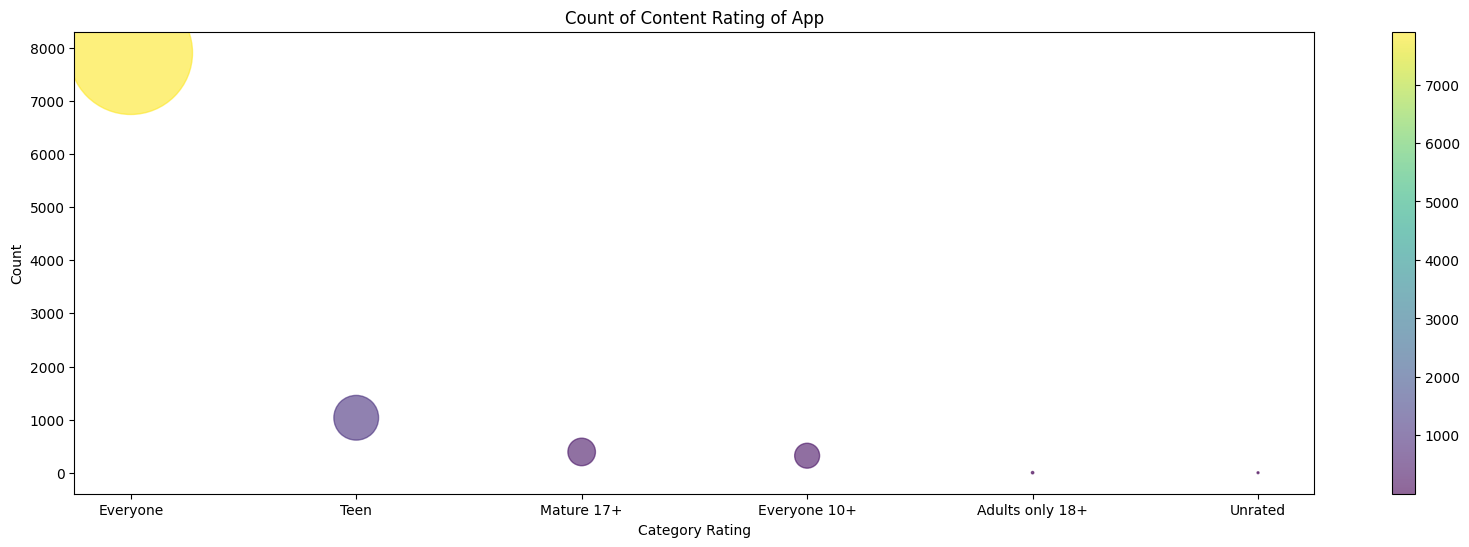

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (34) than needed (33), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (34) than needed (32), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (34) than needed (22), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (34) than needed (26), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (34) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/

<Figure size 2000x600 with 0 Axes>

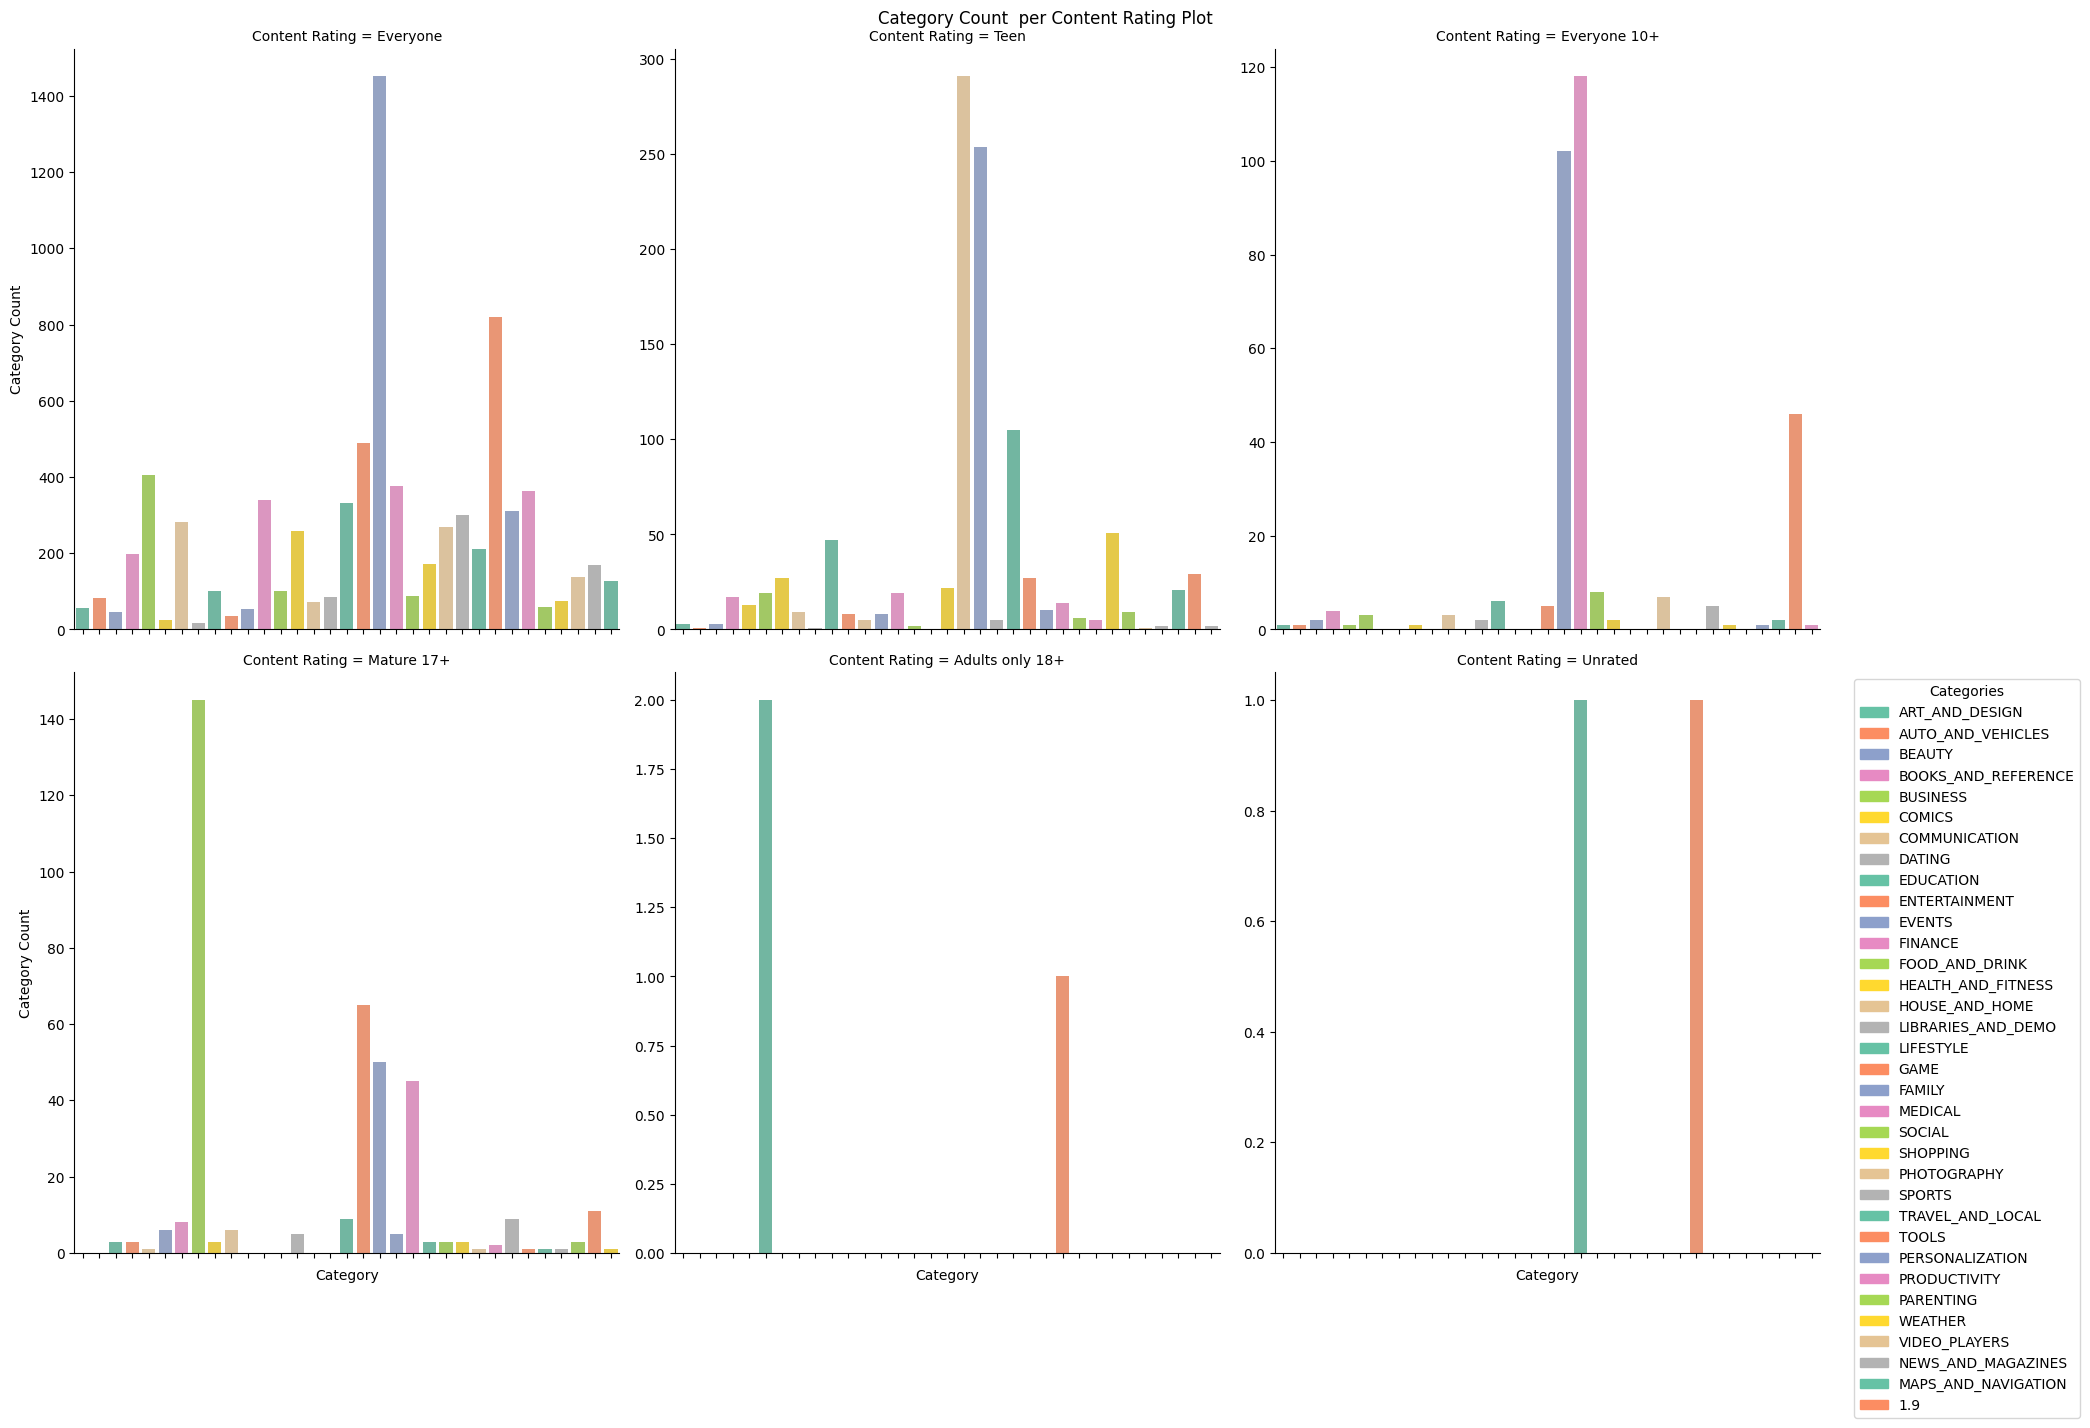

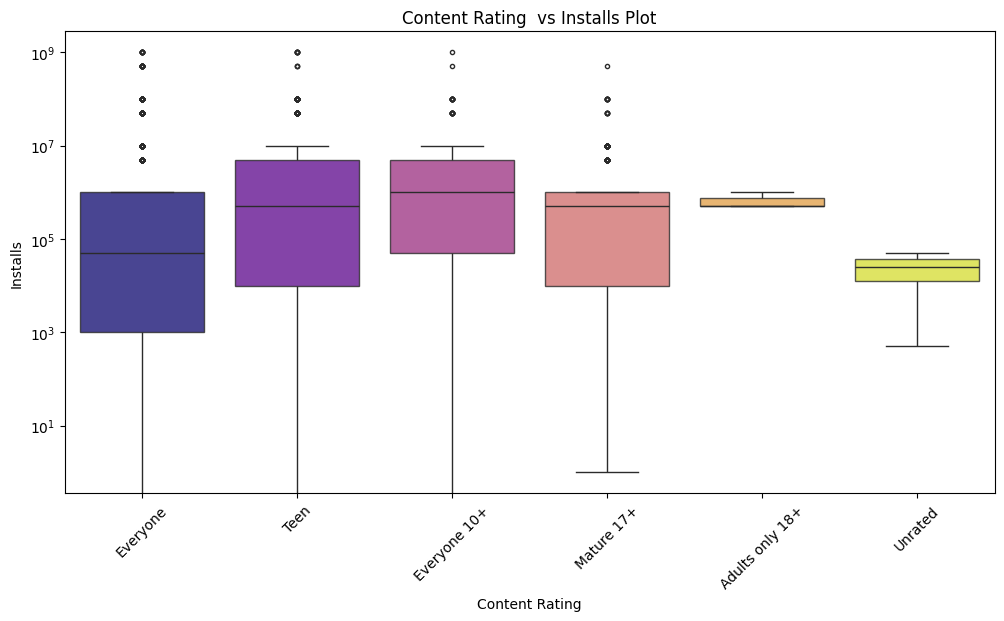

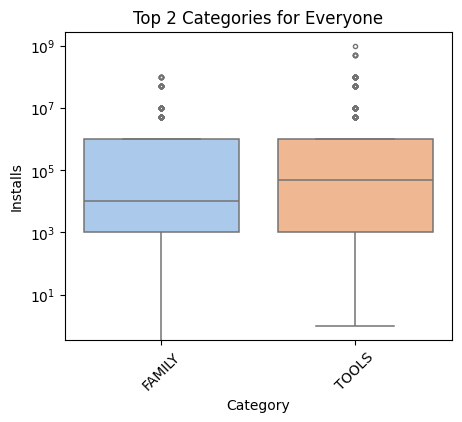

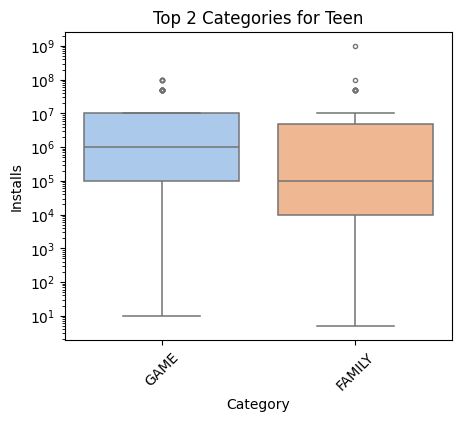

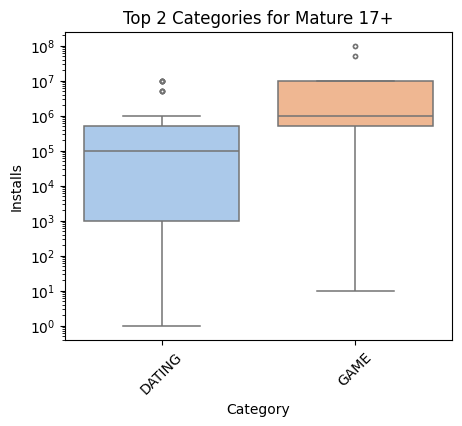

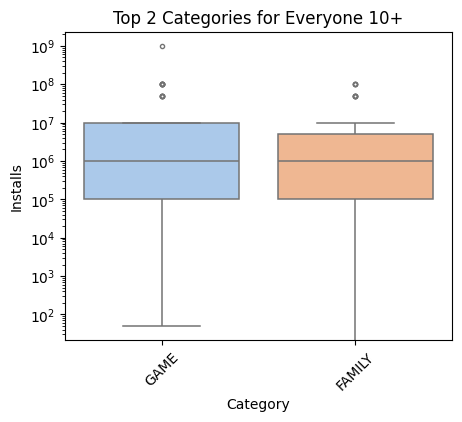

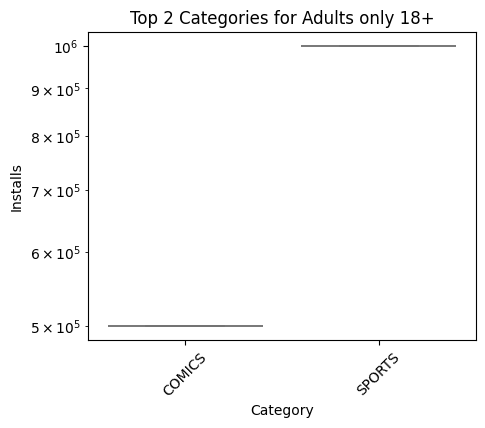

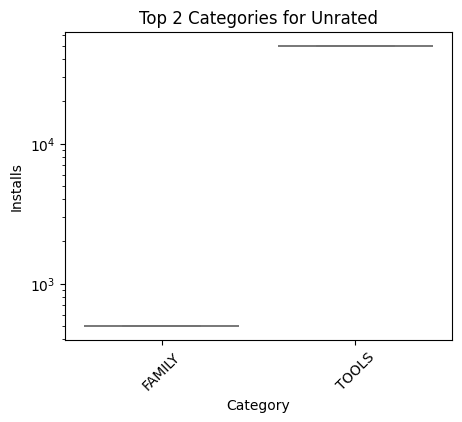

In [63]:
df_apps = pd.read_csv(OUT_APPS)
create_viz_for_content_rating(df_apps,Path(FIG_REV))


### Genre Analysis and Focus Recommendations
This part of the analysis breaks down apps by genre to understand where installs are concentrated and how crowded each space is. By exploding multi-genre apps into individual genres, we can see which genres dominate within big categories like FAMILY and GAME, how often apps use multiple genres, and how installs are distributed across them. The final recommendation step combines app count, total installs, and installs-per-app into a single focus score, helping identify genres that are both popular and efficient (high installs without being overly saturated). These genre focus scores are later used as a feature in the prediction model.


In [64]:
def explode_genres(df: pd.DataFrame) -> pd.DataFrame:
    """
    Explode the Genres column to create one row per genre per app.

    Args:
        df: DataFrame with Genres column containing semicolon-separated values

    Returns:
        DataFrame with exploded genres, one row per genre per app
    """
    # Split genres by semicolon and explode
    df_exploded = df.copy()
    df_exploded['Genre'] = df_exploded['Genres'].str.split(';')
    df_exploded = df_exploded.explode('Genre')

    # Clean up genre names (strip whitespace, standardize)
    df_exploded['Genre'] = df_exploded['Genre'].str.strip()

    # Remove rows with missing genres
    df_exploded = df_exploded[df_exploded['Genre'].notna() & (df_exploded['Genre'] != '')]

    return df_exploded


def compute_genre_statistics(df_exploded: pd.DataFrame) -> pd.DataFrame:
    """
    Compute statistics for each Genre within each Category.

    Args:
        df_exploded: DataFrame with exploded genres

    Returns:
        DataFrame with genre statistics
    """
    # Group by Category and Genre
    stats = df_exploded.groupby(['Category', 'Genre']).agg({
        'App': 'nunique',  # Count unique apps
        'Installs': ['mean', 'median', 'sum'],
        'Rating': 'mean'
    }).reset_index()

    # Flatten column names
    stats.columns = ['Category', 'Genre', 'App_Count', 'Avg_Installs',
                     'Median_Installs', 'Total_Installs', 'Avg_Rating']

    # Add rank within category by Avg_Installs
    stats['Rank_in_Category'] = stats.groupby('Category')['Avg_Installs'].rank(
        ascending=False, method='dense'
    ).astype('Int64')

    # Sort by Category and Rank
    stats = stats.sort_values(['Category', 'Rank_in_Category'])

    return stats


def plot_family_game_genres_comparison(
    stats_df: pd.DataFrame,
    root: Optional[Path] = None,
    output_dir: str = FIG_DIR
) -> None:
    """
    Plot separate bar charts for FAMILY and GAME categories showing app count and installs.
    """


    output_path =  output_dir
    output_path.mkdir(parents=True, exist_ok=True)

    # Plot for FAMILY category
    family_data = stats_df[stats_df['Category'] == 'FAMILY'].sort_values('Total_Installs', ascending=False).head(10)

    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(family_data))
    width = 0.35

    # Normalize installs for better visualization (divide by 1M)
    installs_normalized = family_data['Total_Installs'] / 1_000_000

    bars1 = ax.bar(x - width/2, family_data['App_Count'], width, label='Number of Apps', color='blue', alpha=0.7)
    ax2 = ax.twinx()
    bars2 = ax2.bar(x + width/2, installs_normalized, width, label='Total Installs (M)', color='red', alpha=0.7)

    ax.set_xlabel('Genre', fontsize=12, weight='bold')
    ax.set_ylabel('Number of Apps', fontsize=12, weight='bold', color='blue')
    ax2.set_ylabel('Total Installs (Millions)', fontsize=12, weight='bold', color='red')
    ax.set_title('FAMILY Category: Genres by App Count and Total Installs', fontsize=14, weight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(family_data['Genre'], rotation=45, ha='right')
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    ax.grid(True, alpha=0.3, axis='y')

    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

    plt.tight_layout()
    output_file = output_path / "family_genres_apps_installs.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"FAMILY genre comparison saved to: {output_file}")

    # Plot for GAME category
    game_data = stats_df[stats_df['Category'] == 'GAME'].sort_values('Total_Installs', ascending=False).head(10)

    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(game_data))

    # Normalize installs for better visualization (divide by 1M)
    installs_normalized = game_data['Total_Installs'] / 1_000_000

    bars1 = ax.bar(x - width/2, game_data['App_Count'], width, label='Number of Apps', color='blue', alpha=0.7)
    ax2 = ax.twinx()
    bars2 = ax2.bar(x + width/2, installs_normalized, width, label='Total Installs (M)', color='red', alpha=0.7)

    ax.set_xlabel('Genre', fontsize=12, weight='bold')
    ax.set_ylabel('Number of Apps', fontsize=12, weight='bold', color='blue')
    ax2.set_ylabel('Total Installs (Millions)', fontsize=12, weight='bold', color='red')
    ax.set_title('GAME Category: Genres by App Count and Total Installs', fontsize=14, weight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(game_data['Genre'], rotation=45, ha='right')
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    ax.grid(True, alpha=0.3, axis='y')

    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

    plt.tight_layout()
    output_file = output_path / "game_genres_apps_installs.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"GAME genre comparison saved to: {output_file}")


def plot_multi_genre_analysis_fixed(
    df: pd.DataFrame,
    root: Optional[Path] = None,
    output_dir: str = FIG_DIR
) -> None:
    """Analyze apps with single vs multiple genres - with consistent colors."""


    output_path = output_dir
    output_path.mkdir(parents=True, exist_ok=True)

    # Count genres per app
    df['Genre_Count'] = df['Genres'].str.count(';') + 1
    df.loc[df['Genres'].isna(), 'Genre_Count'] = 0

    # Categorize
    df['Genre_Type'] = df['Genre_Count'].apply(
        lambda x: 'No Genre' if x == 0 else ('Single Genre' if x == 1 else 'Multiple Genres')
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Define consistent colors
    color_map = {
        'No Genre': '#ff9999',
        'Single Genre': '#66b3ff',
        'Multiple Genres': '#99ff99'
    }

    # Pie chart
    genre_type_counts = df['Genre_Type'].value_counts()
    colors_pie = [color_map[label] for label in genre_type_counts.index]
    axes[0].pie(genre_type_counts.values, labels=genre_type_counts.index, autopct='%1.1f%%',
                colors=colors_pie, startangle=90)
    axes[0].set_title('Distribution of Apps by Genre Count', fontsize=12, weight='bold')

    # Bar chart by category
    multi_genre_by_cat = df.groupby(['Category', 'Genre_Type']).size().unstack(fill_value=0)
    multi_genre_by_cat = multi_genre_by_cat.sort_values('Multiple Genres', ascending=False).head(15)

    # Reorder columns to match color_map
    column_order = ['No Genre', 'Single Genre', 'Multiple Genres']
    column_order = [col for col in column_order if col in multi_genre_by_cat.columns]
    multi_genre_by_cat = multi_genre_by_cat[column_order]
    colors_bar = [color_map[col] for col in column_order]

    multi_genre_by_cat.plot(kind='barh', stacked=True, ax=axes[1], color=colors_bar)
    axes[1].set_xlabel('Number of Apps', fontsize=11)
    axes[1].set_ylabel('Category', fontsize=11)
    axes[1].set_title('Genre Count Distribution by Category (Top 15)', fontsize=12, weight='bold')
    axes[1].legend(title='Genre Type', fontsize=9)
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()

    output_file = output_path / "multi_genre_analysis_fixed.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"Multi-genre analysis (fixed colors) saved to: {output_file}")


def plot_all_games_genre_installs(
    df_exploded: pd.DataFrame,
    root: Optional[Path] = None,
    output_dir: str = FIG_DIR
) -> None:
    """
    Plot installs distribution for all GAME genres.
    """


    output_path =  output_dir
    output_path.mkdir(parents=True, exist_ok=True)

    # Filter for GAME category
    game_data = df_exploded[df_exploded['Category'] == 'GAME'].copy()

    # Aggregate by Genre
    genre_stats = game_data.groupby('Genre').agg({
        'App': 'nunique',
        'Installs': ['sum', 'mean', 'median']
    }).reset_index()

    genre_stats.columns = ['Genre', 'App_Count', 'Total_Installs', 'Avg_Installs', 'Median_Installs']
    genre_stats = genre_stats.sort_values('Total_Installs', ascending=False)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Left plot: Total Installs by Genre
    colors1 = plt.cm.viridis(np.linspace(0, 1, len(genre_stats)))
    ax1.barh(genre_stats['Genre'], genre_stats['Total_Installs'] / 1_000_000, color=colors1)
    ax1.set_xlabel('Total Installs (Millions)', fontsize=12, weight='bold')
    ax1.set_ylabel('Genre', fontsize=12, weight='bold')
    ax1.set_title('GAME Category: Total Installs by Genre', fontsize=14, weight='bold')
    ax1.grid(True, alpha=0.3, axis='x')

    # Right plot: App Count vs Average Installs
    colors2 = plt.cm.plasma(np.linspace(0, 1, len(genre_stats)))
    scatter = ax2.scatter(genre_stats['App_Count'], genre_stats['Avg_Installs'] / 1_000_000,
                         s=200, c=range(len(genre_stats)), cmap='plasma', alpha=0.6, edgecolors='black')

    # Add genre labels
    for idx, row in genre_stats.iterrows():
        ax2.annotate(row['Genre'], (row['App_Count'], row['Avg_Installs'] / 1_000_000),
                    fontsize=8, ha='right', va='bottom')

    ax2.set_xlabel('Number of Apps', fontsize=12, weight='bold')
    ax2.set_ylabel('Average Installs (Millions)', fontsize=12, weight='bold')
    ax2.set_title('GAME Category: App Count vs Average Installs', fontsize=14, weight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    output_file = output_path / "game_genres_installs_analysis.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"GAME genres installs analysis saved to: {output_file}")


def analyze_genre_focus_recommendations(
    stats_df: pd.DataFrame,
    root: Optional[Path] = None,
    output_dir: str =FIG_DIR
) -> pd.DataFrame:
    """
    Analyze which genres should be focused on based on app count and installs.
    Returns a DataFrame with recommendations.
    """


    output_path = output_dir
    output_path.mkdir(parents=True, exist_ok=True)

    # Calculate metrics
    genre_summary = stats_df.groupby('Genre').agg({
        'App_Count': 'sum',
        'Total_Installs': 'sum',
        'Avg_Installs': 'mean'
    }).reset_index()

    # Calculate efficiency: Avg Installs per App
    genre_summary['Installs_per_App'] = genre_summary['Total_Installs'] / genre_summary['App_Count']

    # Normalize metrics for scoring
    genre_summary['App_Count_Norm'] = (genre_summary['App_Count'] - genre_summary['App_Count'].min()) / \
                                       (genre_summary['App_Count'].max() - genre_summary['App_Count'].min())
    genre_summary['Installs_Norm'] = (genre_summary['Total_Installs'] - genre_summary['Total_Installs'].min()) / \
                                      (genre_summary['Total_Installs'].max() - genre_summary['Total_Installs'].min())
    genre_summary['Efficiency_Norm'] = (genre_summary['Installs_per_App'] - genre_summary['Installs_per_App'].min()) / \
                                        (genre_summary['Installs_per_App'].max() - genre_summary['Installs_per_App'].min())

    # Combined score: 30% app count, 40% total installs, 30% efficiency
    genre_summary['Focus_Score'] = (0.3 * genre_summary['App_Count_Norm'] +
                                    0.4 * genre_summary['Installs_Norm'] +
                                    0.3 * genre_summary['Efficiency_Norm'])

    genre_summary = genre_summary.sort_values('Focus_Score', ascending=False)

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Top 15 genres by Focus Score
    top_genres = genre_summary.head(15)

    # Plot 1: Focus Score
    colors = plt.cm.RdYlGn(top_genres['Focus_Score'])
    axes[0, 0].barh(top_genres['Genre'], top_genres['Focus_Score'], color=colors)
    axes[0, 0].set_xlabel('Focus Score', fontsize=11, weight='bold')
    axes[0, 0].set_ylabel('Genre', fontsize=11, weight='bold')
    axes[0, 0].set_title('Top 15 Genres by Focus Score', fontsize=12, weight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='x')

    # Plot 2: App Count
    axes[0, 1].barh(top_genres['Genre'], top_genres['App_Count'], color='#4472C4', alpha=0.7)
    axes[0, 1].set_xlabel('Number of Apps', fontsize=11, weight='bold')
    axes[0, 1].set_ylabel('Genre', fontsize=11, weight='bold')
    axes[0, 1].set_title('App Count for Top Genres', fontsize=12, weight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # Plot 3: Total Installs
    axes[1, 0].barh(top_genres['Genre'], top_genres['Total_Installs'] / 1_000_000, color='#ED7D31', alpha=0.7)
    axes[1, 0].set_xlabel('Total Installs (Millions)', fontsize=11, weight='bold')
    axes[1, 0].set_ylabel('Genre', fontsize=11, weight='bold')
    axes[1, 0].set_title('Total Installs for Top Genres', fontsize=12, weight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Plot 4: Installs per App (Efficiency)
    axes[1, 1].barh(top_genres['Genre'], top_genres['Installs_per_App'] / 1_000_000, color='#70AD47', alpha=0.7)
    axes[1, 1].set_xlabel('Avg Installs per App (Millions)', fontsize=11, weight='bold')
    axes[1, 1].set_ylabel('Genre', fontsize=11, weight='bold')
    axes[1, 1].set_title('Efficiency: Installs per App', fontsize=12, weight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')

    plt.suptitle('Genre Focus Recommendations Analysis', fontsize=16, weight='bold', y=0.995)
    plt.tight_layout()

    output_file = output_path / "genre_focus_recommendations.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"Genre focus recommendations saved to: {output_file}")

    # Save recommendations to CSV
    recommendations_file =  "/content/data_processed/genre_focus_recommendations.csv"
    genre_summary[['Genre', 'App_Count', 'Total_Installs', 'Installs_per_App', 'Focus_Score']].to_csv(
        recommendations_file, index=False
    )
    print(f"Recommendations CSV saved to: {recommendations_file}")

    return genre_summary


In [65]:
    print("IMPROVED GENRE ANALYSIS PIPELINE")
    df = pd.read_csv(OUT_APPS)
    df_exploded = explode_genres(df)
    stats_df = compute_genre_statistics(df_exploded)
    stats_output ='data_processed/genre_statistics_v2.csv'
    stats_df.to_csv(stats_output, index=False)
    plot_family_game_genres_comparison(stats_df)
    plot_multi_genre_analysis_fixed(df)
    plot_all_games_genre_installs(df_exploded)
    recommendations = analyze_genre_focus_recommendations(stats_df)
    print(f"\nAll figures saved to: {FIG_APPS}")
    print(f"Statistics saved to: {stats_output}")
    print("\nTop 5 Recommended Genres to Focus On:")
    print(recommendations[['Genre', 'App_Count', 'Total_Installs', 'Focus_Score']].head().to_string(index=False))


IMPROVED GENRE ANALYSIS PIPELINE
FAMILY genre comparison saved to: /content/figs/family_genres_apps_installs.png
GAME genre comparison saved to: /content/figs/game_genres_apps_installs.png
Multi-genre analysis (fixed colors) saved to: /content/figs/multi_genre_analysis_fixed.png
GAME genres installs analysis saved to: /content/figs/game_genres_installs_analysis.png
Genre focus recommendations saved to: /content/figs/genre_focus_recommendations.png
Recommendations CSV saved to: /content/data_processed/genre_focus_recommendations.csv

All figures saved to: /content/figs/apps
Statistics saved to: data_processed/genre_statistics_v2.csv

Top 5 Recommended Genres to Focus On:
        Genre  App_Count  Total_Installs  Focus_Score
Communication        317    1.103978e+10     0.814493
        Tools        829    8.102772e+09     0.677782
       Social        239    5.487868e+09     0.482872
 Productivity        374    5.793091e+09     0.478475
  Photography        281    4.658148e+09     0.4130

This function analyzes how many genres each app belongs to and whether most apps tend to be single-genre or multi-genre. It produces a pie chart of overall genre usage and a bar chart showing which categories contain the most multi-genre apps. The results help identify whether certain categories encourage apps to target multiple genres and how common multi-genre positioning is across the store.

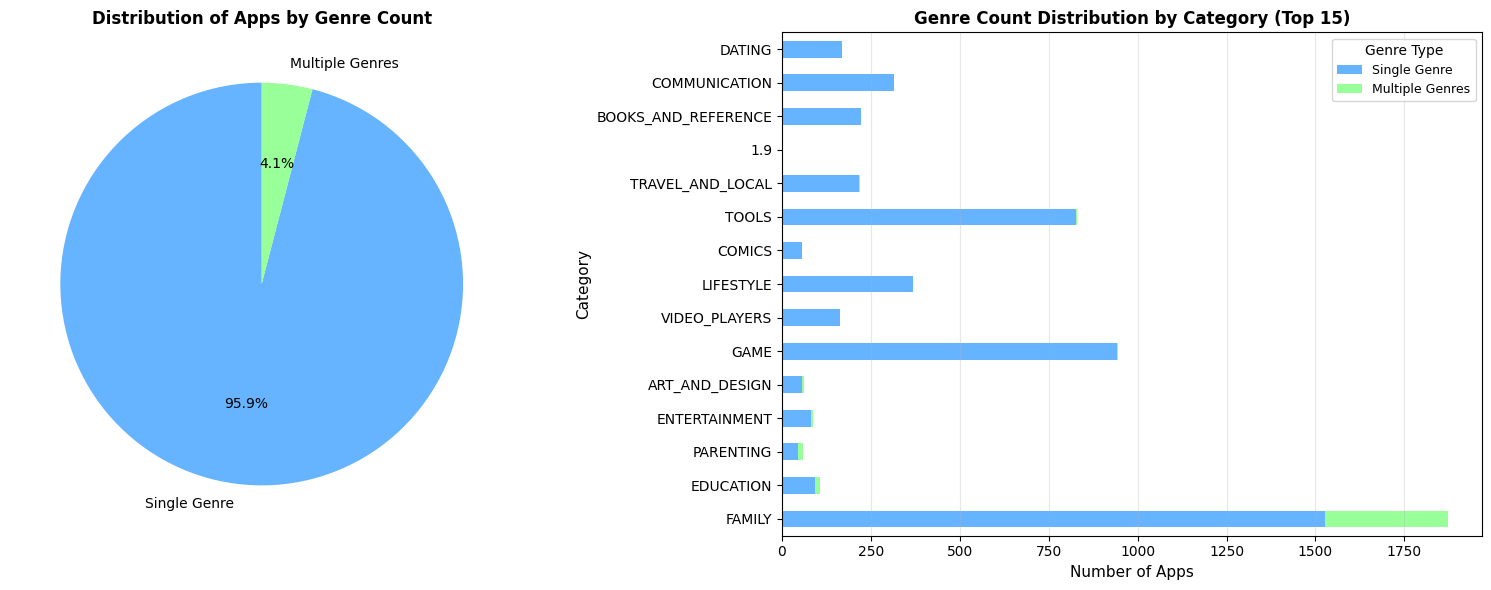

Multi-genre analysis (fixed colors) saved to: /content/figs/apps/multi_genre_analysis_fixed.png


In [66]:
def plot_multi_genre_analysis_fixed(
    df: pd.DataFrame,
    root: Optional[Path] = None,
    output_dir: str = FIG_APPS
) -> None:
    """Analyze apps with single vs multiple genres - with consistent colors."""
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Count genres per app
    df['Genre_Count'] = df['Genres'].str.count(';') + 1
    df.loc[df['Genres'].isna(), 'Genre_Count'] = 0

    # Categorize
    df['Genre_Type'] = df['Genre_Count'].apply(
        lambda x: 'No Genre' if x == 0 else ('Single Genre' if x == 1 else 'Multiple Genres')
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Define consistent colors
    color_map = {
        'No Genre': '#ff9999',
        'Single Genre': '#66b3ff',
        'Multiple Genres': '#99ff99'
    }

    # Pie chart
    genre_type_counts = df['Genre_Type'].value_counts()
    colors_pie = [color_map[label] for label in genre_type_counts.index]
    axes[0].pie(genre_type_counts.values, labels=genre_type_counts.index, autopct='%1.1f%%',
                colors=colors_pie, startangle=90)
    axes[0].set_title('Distribution of Apps by Genre Count', fontsize=12, weight='bold')

    # Bar chart by category
    multi_genre_by_cat = df.groupby(['Category', 'Genre_Type']).size().unstack(fill_value=0)
    multi_genre_by_cat = multi_genre_by_cat.sort_values('Multiple Genres', ascending=False).head(15)

    # Reorder columns to match color_map
    column_order = ['No Genre', 'Single Genre', 'Multiple Genres']
    column_order = [col for col in column_order if col in multi_genre_by_cat.columns]
    multi_genre_by_cat = multi_genre_by_cat[column_order]
    colors_bar = [color_map[col] for col in column_order]

    multi_genre_by_cat.plot(kind='barh', stacked=True, ax=axes[1], color=colors_bar)
    axes[1].set_xlabel('Number of Apps', fontsize=11)
    axes[1].set_ylabel('Category', fontsize=11)
    axes[1].set_title('Genre Count Distribution by Category (Top 15)', fontsize=12, weight='bold')
    axes[1].legend(title='Genre Type', fontsize=9)
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()

    output_file = output_path / "multi_genre_analysis_fixed.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    print(f"Multi-genre analysis (fixed colors) saved to: {output_file}")
plot_multi_genre_analysis_fixed(df)

This function focuses specifically on the GAME category and compares all game genres by install performance. It visualizes total installs for each game genre and shows how average installs relate to the number of apps in that genre. The plots reveal which game genres attract the largest audiences, which ones are crowded, and which combine strong popularity with a manageable number of competitors.

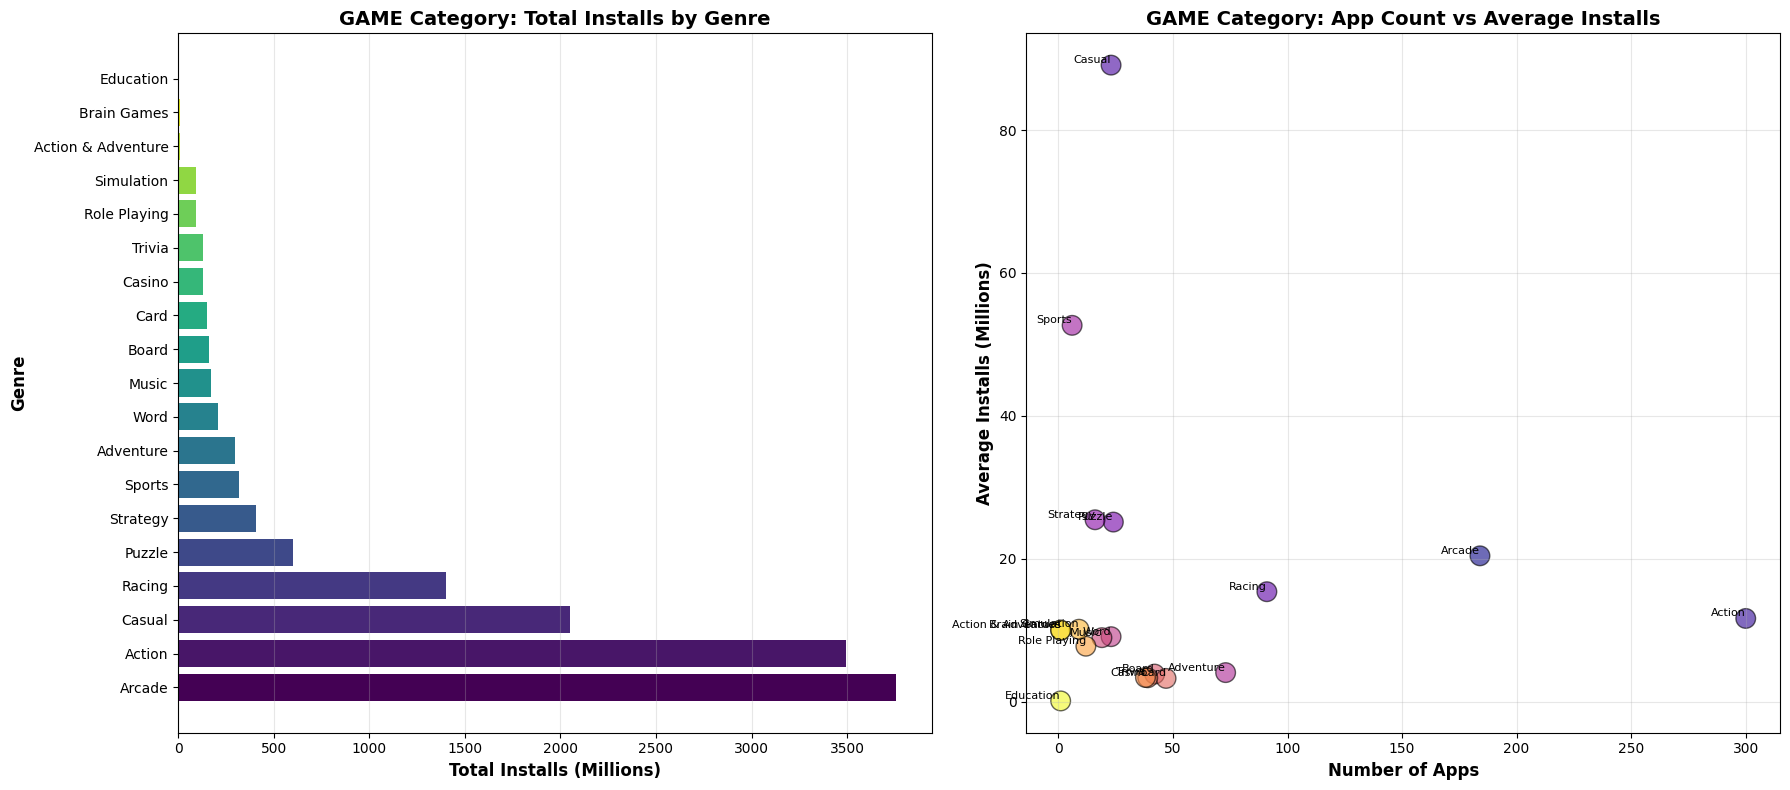

GAME genres installs analysis saved to: /content/figs/apps/game_genres_installs_analysis.png


In [67]:
def plot_all_games_genre_installs(
    df_exploded: pd.DataFrame,
    root: Optional[Path] = None,
    output_dir: str = FIG_APPS
) -> None:
    """
    Plot installs distribution for all GAME genres.
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Filter for GAME category
    game_data = df_exploded[df_exploded['Category'] == 'GAME'].copy()

    # Aggregate by Genre
    genre_stats = game_data.groupby('Genre').agg({
        'App': 'nunique',
        'Installs': ['sum', 'mean', 'median']
    }).reset_index()

    genre_stats.columns = ['Genre', 'App_Count', 'Total_Installs', 'Avg_Installs', 'Median_Installs']
    genre_stats = genre_stats.sort_values('Total_Installs', ascending=False)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Left plot: Total Installs by Genre
    colors1 = plt.cm.viridis(np.linspace(0, 1, len(genre_stats)))
    ax1.barh(genre_stats['Genre'], genre_stats['Total_Installs'] / 1_000_000, color=colors1)
    ax1.set_xlabel('Total Installs (Millions)', fontsize=12, weight='bold')
    ax1.set_ylabel('Genre', fontsize=12, weight='bold')
    ax1.set_title('GAME Category: Total Installs by Genre', fontsize=14, weight='bold')
    ax1.grid(True, alpha=0.3, axis='x')

    # Right plot: App Count vs Average Installs
    colors2 = plt.cm.plasma(np.linspace(0, 1, len(genre_stats)))
    scatter = ax2.scatter(genre_stats['App_Count'], genre_stats['Avg_Installs'] / 1_000_000,
                         s=200, c=range(len(genre_stats)), cmap='plasma', alpha=0.6, edgecolors='black')

    # Add genre labels
    for idx, row in genre_stats.iterrows():
        ax2.annotate(row['Genre'], (row['App_Count'], row['Avg_Installs'] / 1_000_000),
                    fontsize=8, ha='right', va='bottom')

    ax2.set_xlabel('Number of Apps', fontsize=12, weight='bold')
    ax2.set_ylabel('Average Installs (Millions)', fontsize=12, weight='bold')
    ax2.set_title('GAME Category: App Count vs Average Installs', fontsize=14, weight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    output_file = output_path / "game_genres_installs_analysis.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    print(f"GAME genres installs analysis saved to: {output_file}")
plot_all_games_genre_installs(df_exploded)

###analyze_genre_focus_recommendations(stats_df)
This function turns the genre stats into an actionable recommendation list. It aggregates app count, total installs, and installs-per-app for each genre and normalizes these three metrics to build a single Focus_Score (30% app count, 40% total installs, 30% efficiency). The plots show, for the top 15 genres, how that score relates to raw popularity and efficiency, and the exported CSV is used later as a “genre_focus” signal in the prediction model. In practice, this highlights genres that are both widely installed and efficient (many installs per app), making them good strategic targets rather than just the most crowded ones.



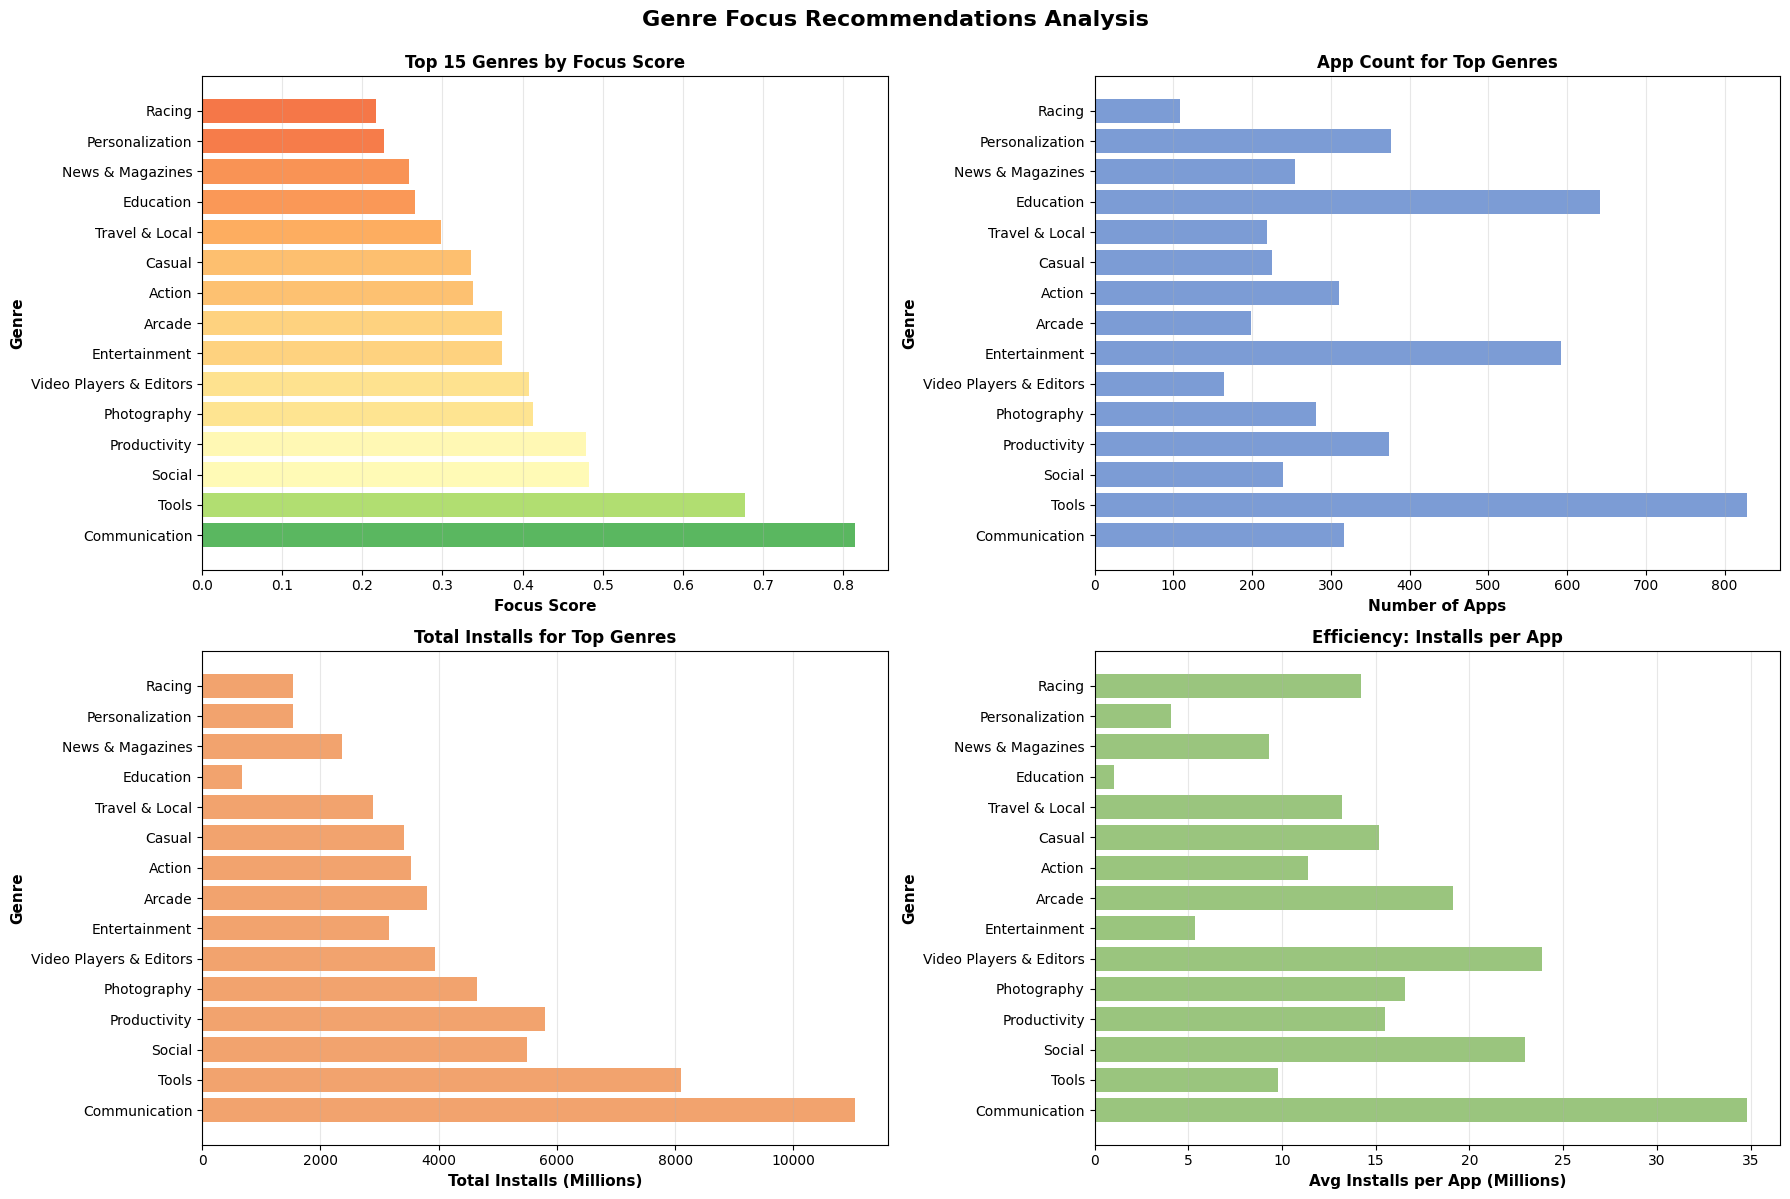

Genre focus recommendations saved to: /content/figs/apps/genre_focus_recommendations.png
Recommendations CSV saved to: /content/data_processedgenre_focus_recommendations.csv


In [68]:
def analyze_genre_focus_recommendations(
    stats_df: pd.DataFrame,
    root: Optional[Path] = None,
    output_dir: str = FIG_APPS
) -> pd.DataFrame:
    """
    Analyze which genres should be focused on based on app count and installs.
    Returns a DataFrame with recommendations.
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Calculate metrics
    genre_summary = stats_df.groupby('Genre').agg({
        'App_Count': 'sum',
        'Total_Installs': 'sum',
        'Avg_Installs': 'mean'
    }).reset_index()

    # Calculate efficiency: Avg Installs per App
    genre_summary['Installs_per_App'] = genre_summary['Total_Installs'] / genre_summary['App_Count']

    # Normalize metrics for scoring
    genre_summary['App_Count_Norm'] = (genre_summary['App_Count'] - genre_summary['App_Count'].min()) / \
                                       (genre_summary['App_Count'].max() - genre_summary['App_Count'].min())
    genre_summary['Installs_Norm'] = (genre_summary['Total_Installs'] - genre_summary['Total_Installs'].min()) / \
                                      (genre_summary['Total_Installs'].max() - genre_summary['Total_Installs'].min())
    genre_summary['Efficiency_Norm'] = (genre_summary['Installs_per_App'] - genre_summary['Installs_per_App'].min()) / \
                                        (genre_summary['Installs_per_App'].max() - genre_summary['Installs_per_App'].min())

    # Combined score: 30% app count, 40% total installs, 30% efficiency
    genre_summary['Focus_Score'] = (0.3 * genre_summary['App_Count_Norm'] +
                                    0.4 * genre_summary['Installs_Norm'] +
                                    0.3 * genre_summary['Efficiency_Norm'])

    genre_summary = genre_summary.sort_values('Focus_Score', ascending=False)

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Top 15 genres by Focus Score
    top_genres = genre_summary.head(15)

    # Plot 1: Focus Score
    colors = plt.cm.RdYlGn(top_genres['Focus_Score'])
    axes[0, 0].barh(top_genres['Genre'], top_genres['Focus_Score'], color=colors)
    axes[0, 0].set_xlabel('Focus Score', fontsize=11, weight='bold')
    axes[0, 0].set_ylabel('Genre', fontsize=11, weight='bold')
    axes[0, 0].set_title('Top 15 Genres by Focus Score', fontsize=12, weight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='x')

    # Plot 2: App Count
    axes[0, 1].barh(top_genres['Genre'], top_genres['App_Count'], color='#4472C4', alpha=0.7)
    axes[0, 1].set_xlabel('Number of Apps', fontsize=11, weight='bold')
    axes[0, 1].set_ylabel('Genre', fontsize=11, weight='bold')
    axes[0, 1].set_title('App Count for Top Genres', fontsize=12, weight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # Plot 3: Total Installs
    axes[1, 0].barh(top_genres['Genre'], top_genres['Total_Installs'] / 1_000_000, color='#ED7D31', alpha=0.7)
    axes[1, 0].set_xlabel('Total Installs (Millions)', fontsize=11, weight='bold')
    axes[1, 0].set_ylabel('Genre', fontsize=11, weight='bold')
    axes[1, 0].set_title('Total Installs for Top Genres', fontsize=12, weight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Plot 4: Installs per App (Efficiency)
    axes[1, 1].barh(top_genres['Genre'], top_genres['Installs_per_App'] / 1_000_000, color='#70AD47', alpha=0.7)
    axes[1, 1].set_xlabel('Avg Installs per App (Millions)', fontsize=11, weight='bold')
    axes[1, 1].set_ylabel('Genre', fontsize=11, weight='bold')
    axes[1, 1].set_title('Efficiency: Installs per App', fontsize=12, weight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')

    plt.suptitle('Genre Focus Recommendations Analysis', fontsize=16, weight='bold', y=0.995)
    plt.tight_layout()

    output_file = output_path / "genre_focus_recommendations.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    print(f"Genre focus recommendations saved to: {output_file}")

    # Save recommendations to CSV
    recommendations_file = "/content/data_processedgenre_focus_recommendations.csv"
    genre_summary[['Genre', 'App_Count', 'Total_Installs', 'Installs_per_App', 'Focus_Score']].to_csv(
        recommendations_file, index=False
    )
    print(f"Recommendations CSV saved to: {recommendations_file}")

    return genre_summary
recommendations = analyze_genre_focus_recommendations(stats_df)

###get_high_rating_low_installs, plot_high_rating_low_installs
These functions look for apps that are highly rated but barely downloaded and visualize them on a rating–installs scatter plot. They help surface “hidden gems”: apps that users love (rating above a threshold like 4.5) but that have very low install counts. This gives insight into potential opportunities where quality doesn’t yet match visibility or marketing reach.

###plot_high_rating_low_installs_by_month
This function takes those high-rating, low-install apps and looks at when they were last updated, aggregating them by year–month. The bar chart, colored by year, shows whether these overlooked high-quality apps are mostly old (possibly abandoned) or if a lot of them are recent and simply haven’t gained traction yet. That gives context on whether the “hidden gem” problem is historical or ongoing.

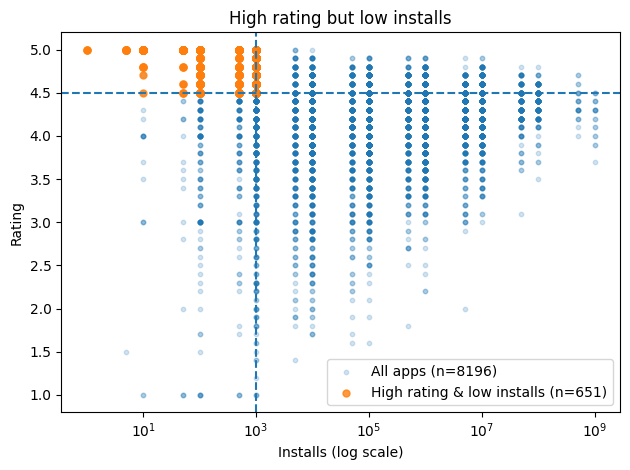

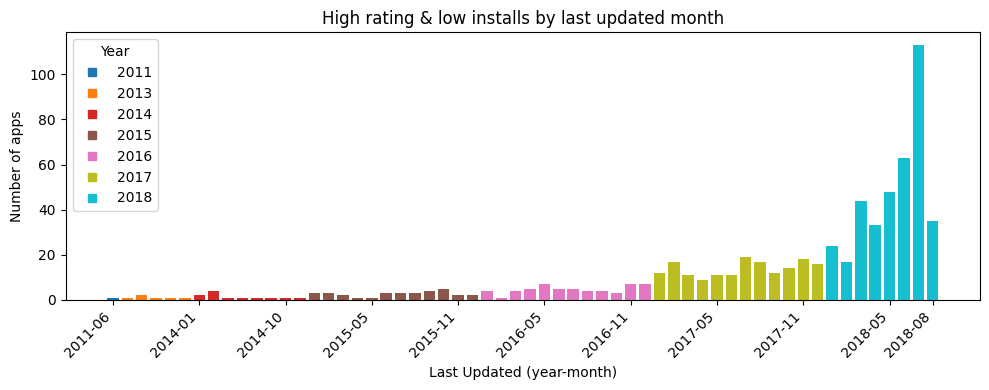

In [69]:
def get_high_rating_low_installs(df, rating_thresh=4.5, install_thresh=1000):
    """
    Return subset of apps with high rating and low installs.
    """
    df = df.dropna(subset=["Rating", "Installs"])
    mask = (df["Rating"] >= rating_thresh) & (df["Installs"] <= install_thresh)
    return df[mask]


def plot_high_rating_low_installs(df, rating_thresh=4.5, install_thresh=1000):
    """
    Scatter plot highlighting high rating and low installs apps.
    """
    sub = df.dropna(subset=["Rating", "Installs"])
    highlighted = get_high_rating_low_installs(sub, rating_thresh, install_thresh)

    fig, ax = plt.subplots()

    ax.scatter(
        sub["Installs"],
        sub["Rating"],
        alpha=0.2,
        s=10,
        label=f"All apps (n={len(sub)})",
    )
    ax.scatter(
        highlighted["Installs"],
        highlighted["Rating"],
        alpha=0.8,
        s=25,
        label=f"High rating & low installs (n={len(highlighted)})",
    )

    ax.axhline(rating_thresh, linestyle="--")
    ax.axvline(install_thresh, linestyle="--")

    ax.set_xscale("log")
    ax.set_xlabel("Installs (log scale)")
    ax.set_ylabel("Rating")
    ax.set_title("High rating but low installs")

    ax.legend()
    plt.tight_layout()
    plt.show()
plot_high_rating_low_installs(df)

def plot_high_rating_low_installs_by_month(df, rating_thresh=4.5, install_thresh=1000):
    """
    Bar chart of high rating, low install apps by last updated month,
    with different colors for different years.
    """
    subset = get_high_rating_low_installs(df, rating_thresh, install_thresh).copy()
    subset["LastUpdated_dt"] = pd.to_datetime(subset["Last Updated"], errors="coerce")
    subset = subset.dropna(subset=["LastUpdated_dt"])

    subset["year_month"] = subset["LastUpdated_dt"].dt.to_period("M").astype(str)
    month_counts = subset["year_month"].value_counts().sort_index()

    months = list(month_counts.index)
    years = [m[:4] for m in months]
    unique_years = sorted(set(years))

    cmap = plt.get_cmap("tab10", len(unique_years))
    colors = [cmap(unique_years.index(y)) for y in years]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(range(len(month_counts)), month_counts.values, color=colors)

    ax.set_xlabel("Last Updated (year-month)")
    ax.set_ylabel("Number of apps")
    ax.set_title("High rating & low installs by last updated month")

    step = 6
    tick_idx = list(range(0, len(month_counts), step))
    last_idx = len(month_counts) - 1
    if last_idx not in tick_idx:
        tick_idx.append(last_idx)
    tick_idx = sorted(tick_idx)

    ax.set_xticks(tick_idx)
    ax.set_xticklabels([months[i] for i in tick_idx], rotation=45, ha="right")

    handles = []
    labels = []
    for i, y in enumerate(unique_years):
        handles.append(
            plt.Line2D(
                [0],
                [0],
                color=cmap(i),
                marker="s",
                linestyle="",
            )
        )
        labels.append(y)
    ax.legend(handles, labels, title="Year", loc="upper left")

    plt.tight_layout()
    plt.show()

plot_high_rating_low_installs_by_month(df)

###count_nan_rating_low_installs, count_nan_rating_high_installs, plot_nan_rating_pie_all
These functions focus on apps with missing ratings and split them into low-install and high-install groups. The final pie chart shows how large the “no rating” segment is compared with all other apps, and whether unrated apps are mostly in the long tail (low installs) or if a non-trivial share of popular apps also lack ratings. This helps judge how much the absence of rating data might bias the analysis and whether missing ratings are primarily a problem among obscure apps or more widespread.

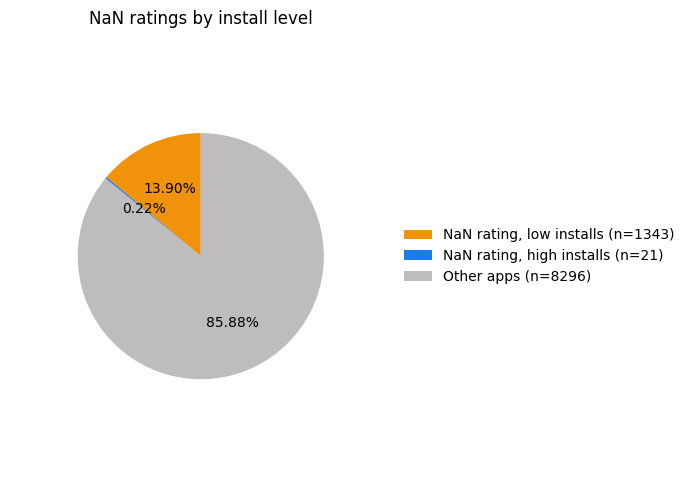

In [70]:
def count_nan_rating_low_installs(df, low_thresh):
    """
    Count apps with NaN rating and low installs.
    """
    nan_rating_df = df[df['Rating'].isna()]
    low_installs = nan_rating_df[nan_rating_df['Installs'] <= low_thresh]
    return len(low_installs)


def count_nan_rating_high_installs(df, high_thresh):
    """
    Count apps with NaN rating and high installs.
    """
    nan_rating_df = df[df['Rating'].isna()]
    high_installs = nan_rating_df[nan_rating_df['Installs'] >= high_thresh]
    return len(high_installs)


def plot_nan_rating_pie_all(df, low_thresh=1000, high_thresh=100000):
    """
    Pie chart of NaN rating apps relative to all apps.
    """
    total_apps = len(df)
    low_count = count_nan_rating_low_installs(df, low_thresh)
    high_count = count_nan_rating_high_installs(df, high_thresh)
    other_count = total_apps - low_count - high_count

    labels = [
        "NaN rating, low installs",
        "NaN rating, high installs",
        "Other apps",
    ]
    print()
    sizes = [low_count, high_count, other_count]
    colors = ["#F1920B", "#197CEC", "#BEBCBC"]

    fig, ax = plt.subplots(figsize=(7, 5))
    wedges, texts, autotexts = ax.pie(
        sizes,
        colors=colors,
        autopct="%.2f%%",
        startangle=90,
        textprops={"fontsize": 10},
    )
    ax.set_title("NaN ratings by install level", fontsize=12)
    ax.axis("equal")

    legend_labels = [
        f"{labels[0]} (n={low_count})",
        f"{labels[1]} (n={high_count})",
        f"{labels[2]} (n={other_count})",
    ]
    ax.legend(
        wedges,
        legend_labels,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    plt.show()
plot_nan_rating_pie_all(df)

# Model prediction using best features
This section engineers a set of features describing each app (review volume, rating behavior over time, developer update activity, content targeting, genre focus, and category dummies) and trains a multinomial logistic regression model to predict the app’s install level (from low <10K to high >10M installs). The evaluation with accuracy, balanced accuracy, confusion matrix, and prediction distribution plots shows how well these non-sentiment features explain popularity, while the coefficient analysis highlights which signals most strongly push an app into the “High installs” class. This modeling step emphasizes that structural factors like review volume and app/developer characteristics are more informative for popularity than the sentiment CSV alone. These insights were obtained after doing analysis part.

### categorize_installs(installs)
Maps raw install counts into five ordered buckets (0–4) so that popularity is modeled as a multiclass classification problem instead of a continuous value.

### compute_rating_dynamic_score(row)
Builds a rating score that depends on both the app’s star rating and how recently it was updated, rewarding new apps that maintain high ratings and slightly relaxing the bar for older apps.

### compute_developer_activity_score(row)
Combines update recency and required Android version into a single score to capture whether an app looks like a long-term, actively maintained project.

### compute_content_rating_targeted_score(content_rating)
Assigns a higher score to more targeted content ratings (Teen, Mature 17+, Everyone 10+) than to generic or unclear ratings, as a proxy for how specifically the app is positioned.

### get_genre_focus_score(genres_str, genre_scores_dict)
Looks up a precomputed “focus” score for the app’s primary genre to reflect how aligned that genre is with recommended or successful categories.

### engineer_features(df, genre_scores_dict=None)
Constructs the full feature matrix for modeling, heavily weighting log-transformed review counts and adding rating dynamics, activity, pricing, targeting, optional genre focus, and one-hot encoded categories.

### train_logistic_regression(...)
Loads the cleaned app data, builds the target install levels and engineered features, trains a balanced multinomial logistic regression model, evaluates its performance, and generates plots and CSVs for results, confusion matrix, and feature importance, so we can see both how well the model predicts install tiers and which features matter most for high installs.


LOGISTIC REGRESSION MODEL FOR INSTALL PREDICTION
Loaded 9660 apps
After removing missing Installs and Reviews: 9659 apps
Genre scores file not found, skipping this feature. Please ensure it's generated.
Target distribution:
  Level 0 (Low (<10K)): 3145 (32.6%)
  Level 1 (Medium-Low (10K-100K)): 1500 (15.5%)
  Level 2 (Medium (100K-1M)): 1616 (16.7%)
  Level 3 (Medium-High (1M-10M)): 2024 (21.0%)
  Level 4 (High (>10M)): 1374 (14.2%)
Created 41 features
Feature names: ['reviews_log_1', 'reviews_log_2', 'reviews_log_3', 'reviews_log_4', 'reviews_log_5', 'rating_dynamic', 'price_free', 'dev_activity', 'content_targeted', 'Cat_AUTO_AND_VEHICLES']... (showing first 10)
Training set: 7727 samples
Test set: 1932 samples
Training complete!

Accuracy: 0.8111
Balanced Accuracy: 0.8038

Classification Report:
                       precision    recall  f1-score   support

           Low (<10K)       0.96      0.89      0.92       629
Medium-Low (10K-100K)       0.65      0.81      0.72       300


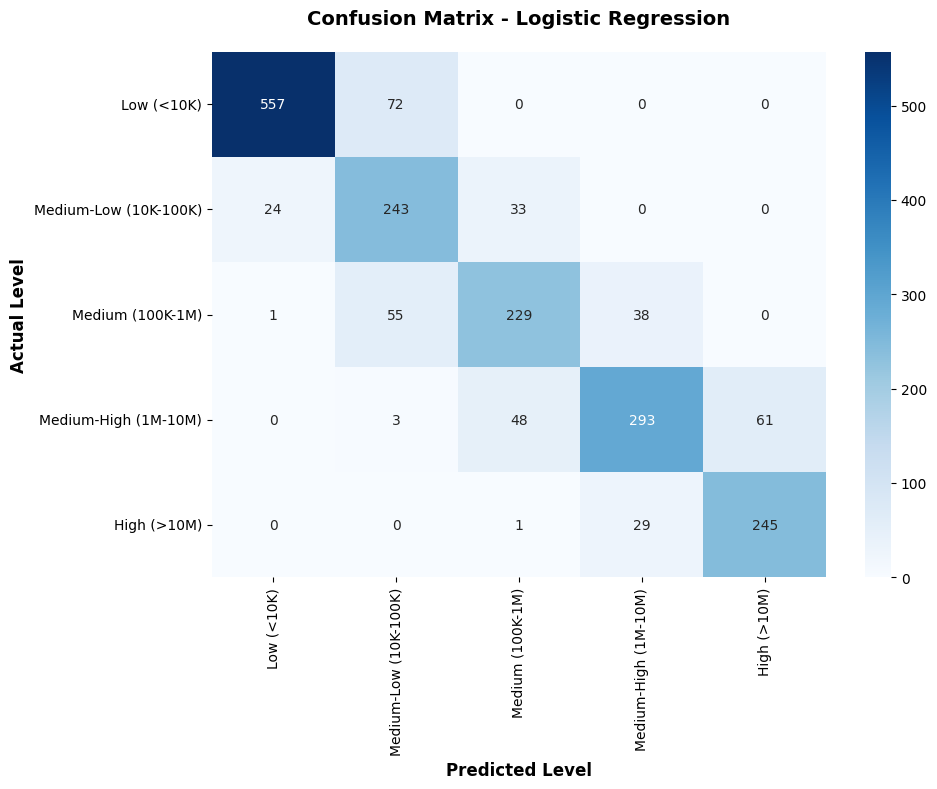

Saved: /content/figs/prediction/confusion_matrix_logistic.png


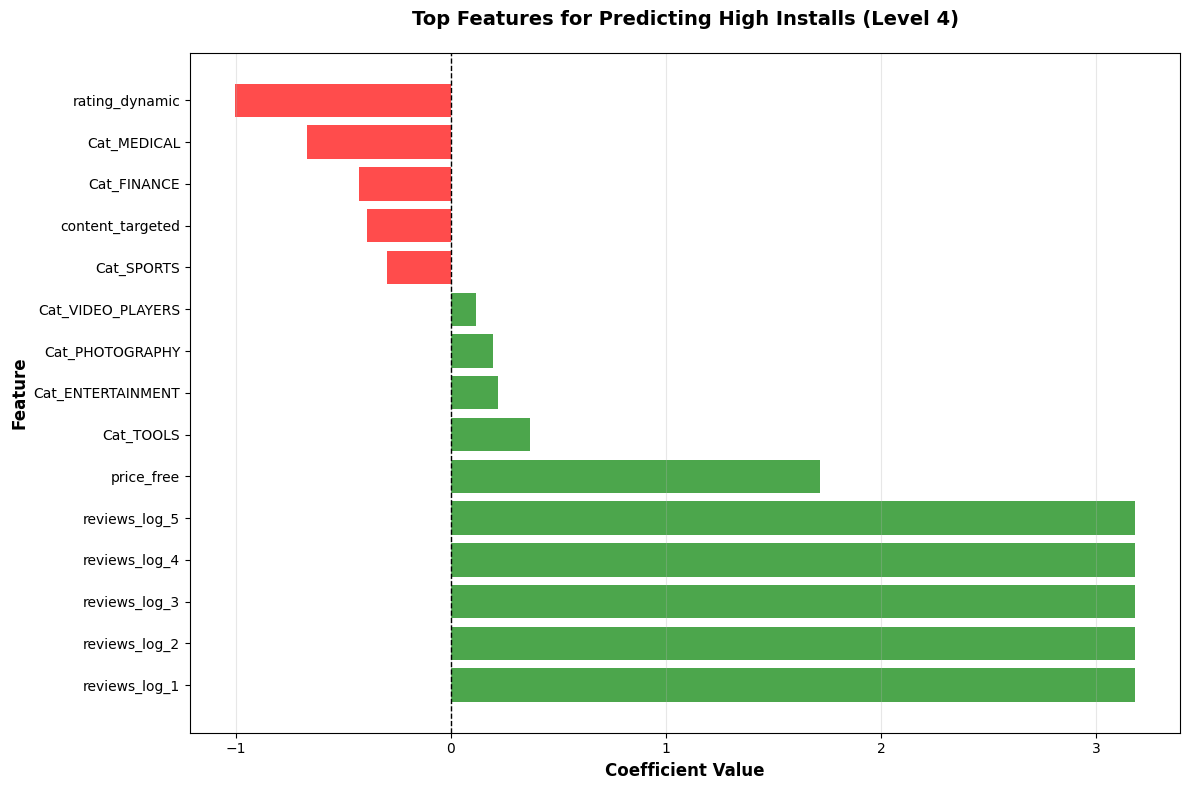

Saved: /content/figs/prediction/feature_coefficients_logistic.png


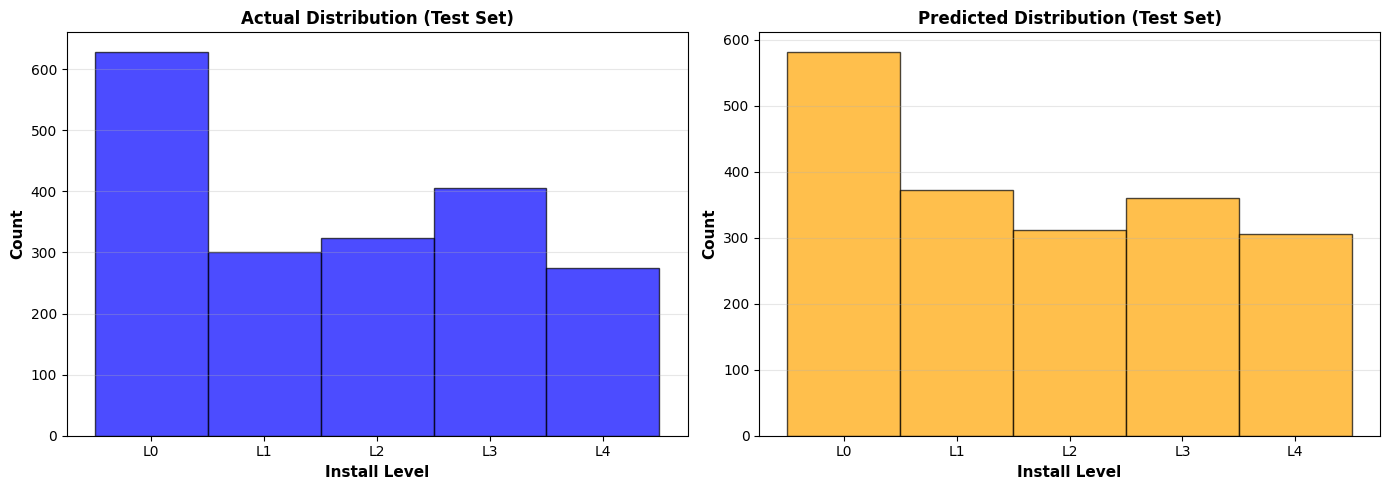

Saved: /content/figs/prediction/prediction_distribution_logistic.png


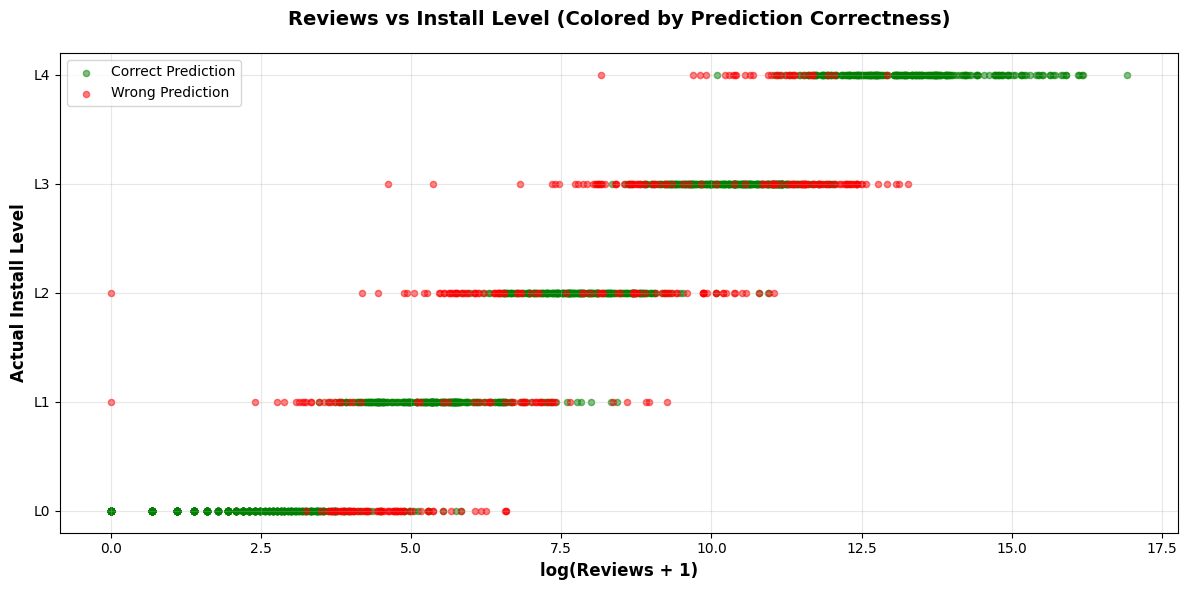

Saved: /content/figs/prediction/reviews_vs_installs_correctness.png

Results saved to: /content/figs/prediction
top 10 most important features (for high installs):
          feature  coefficient
    reviews_log_1     3.179092
    reviews_log_2     3.179092
    reviews_log_3     3.179092
    reviews_log_4     3.179092
    reviews_log_5     3.179092
       price_free     1.716302
        Cat_TOOLS     0.367228
Cat_ENTERTAINMENT     0.218195
  Cat_PHOTOGRAPHY     0.197848
Cat_VIDEO_PLAYERS     0.117746


In [71]:
from typing import Optional
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score
)
from sklearn.preprocessing import StandardScaler


def categorize_installs(installs):
    """
    Categorize installs into 5 levels.

    Args:
        installs: Number of installs

    Returns:
        int: Install level (0-4)
    """
    if installs < 10000:
        return 0  # Low
    elif installs < 100000:
        return 1  # Medium-Low
    elif installs < 1000000:
        return 2  # Medium
    elif installs < 10000000:
        return 3  # Medium-High
    else:
        return 4  # High


def compute_rating_dynamic_score(row):
    """
    Compute dynamic rating score based on app age. New apps need higher ratings, old apps can have slightly lower ratings.
    Args: row: DataFrame row with Rating and Last Updated
    Returns:float: Rating score (0-1)
    """
    rating = row['Rating']

    if pd.isna(rating):
        return 0.5  # Default for missing ratings

    try:
        last_updated = pd.to_datetime(row['Last Updated'])
        days_since_update = (pd.Timestamp.now() - last_updated).days
    except:
        days_since_update = 365  # Default to "old" if parsing fails

    # New app (< 6 months)
    if days_since_update < 180:
        if rating >= 4.5:
            return 1.0
        elif rating >= 4.0:
            return 0.7
        else:
            return 0.3
    # Old app (>= 6 months)
    else:
        if rating >= 4.2:
            return 1.0
        elif rating >= 3.8:
            return 0.6
        else:
            return 0.2


def compute_developer_activity_score(row):
    """
    Compute developer activity score combining update recency and app age. Ideally Recently updated + Old Android version = Long-term maintained mature app.
    Args: row: DataFrame row with Last Updated and Android Ver
    Returns: float: Developer activity score (0-1)
    """
    try:
        last_updated = pd.to_datetime(row['Last Updated'])
        days_since_update = (pd.Timestamp.now() - last_updated).days
    except:
        days_since_update = 365  # Default

    # Update recency score (more recent = better)
    if days_since_update < 90:
        update_score = 1.0
    elif days_since_update < 180:
        update_score = 0.8
    elif days_since_update < 365:
        update_score = 0.6
    else:
        update_score = 0.3

    # Android version score (older version = app exists longer)
    android_ver = row['Android Ver']
    if pd.isna(android_ver):
        version_score = 0.5  # Default
    elif android_ver <= 3:
        version_score = 1.0  # Old app, exists long time
    elif android_ver == 4:
        version_score = 0.7  # Medium
    else:
        version_score = 0.5  # New app

    # Combined score: 40% update frequency + 60% app age
    activity_score = 0.4 * update_score + 0.6 * version_score

    return activity_score


def compute_content_rating_targeted_score(content_rating):
    """
    Compute content rating targeting score.
    More targeted ratings (Teen, Mature, 10+) are better than generic (Everyone).
    Args:content_rating: Content rating string
    Returns:float: Targeting score (0-1)
    """
    if pd.isna(content_rating):
        return 0.5

    content_rating = str(content_rating).strip()

    if content_rating in ['Teen', 'Mature 17+', 'Everyone 10+']:
        return 1.0  # Targeted
    elif content_rating == 'Everyone':
        return 0.5  # Generic
    else:
        return 0.3  # Other (Adults only, Unrated, etc.)


def get_genre_focus_score(genres_str, genre_scores_dict):
    """
    Get genre focus score from pre-computed genre recommendations.
    Args:
        genres_str: Semicolon-separated genres string
        genre_scores_dict: Dictionary mapping genre to focus score
    Returns:
        float: Genre focus score (0-1)
    """
    if pd.isna(genres_str):
        return 0.5  # Default

    # Take first genre
    first_genre = str(genres_str).split(';')[0].strip()
    return genre_scores_dict.get(first_genre, 0.5)


def engineer_features(df, genre_scores_dict=None):
    """
    Engineer all features for prediction.
    Args:
        df: Input DataFrame
        genre_scores_dict: Optional genre scores dictionary
    Returns:
        pd.DataFrame: Feature matrix
    """
    X = pd.DataFrame(index=df.index)

    # Feature 1: Reviews (log transformed) - MOST IMPORTANT
    # Weight: 5x (implemented by replicating the feature)
    reviews_log = np.log1p(df['Reviews'].fillna(0))
    X['reviews_log_1'] = reviews_log
    X['reviews_log_2'] = reviews_log
    X['reviews_log_3'] = reviews_log
    X['reviews_log_4'] = reviews_log
    X['reviews_log_5'] = reviews_log

    # Feature 2: Rating × Last Updated (dynamic rating score)
    X['rating_dynamic'] = df.apply(compute_rating_dynamic_score, axis=1)

    # Feature 3: Price (Free vs Paid binary)
    X['price_free'] = (df['Price'].fillna(0) == 0).astype(int)

    # Feature 4: Developer Activity Score
    X['dev_activity'] = df.apply(compute_developer_activity_score, axis=1)

    # Feature 5: Content Rating (targeting score)
    X['content_targeted'] = df['Content Rating'].apply(compute_content_rating_targeted_score)

    # Feature 6: Genre Focus Score (if available)
    if genre_scores_dict is not None:
        X['genre_focus'] = df['Genres'].apply(
            lambda x: get_genre_focus_score(x, genre_scores_dict)
        )

    # Feature 7: Category (One-Hot encoding)
    category_dummies = pd.get_dummies(df['Category'], prefix='Cat', drop_first=True)
    X = pd.concat([X, category_dummies], axis=1)

    return X


def train_logistic_regression(
    root: Optional[Path] = None,
    csv_path: str = OUT_APPS,
    genre_scores_path: str = "/content/data_processed/data_processedgenre_focus_recommendations.csv",
    output_dir: str = "/content/figs/prediction"
):
    """
    Train Logistic Regression model for install level prediction.
    Args:
        root: Root directory
        csv_path: Path to cleaned data
        genre_scores_path: Path to genre scores
        output_dir: Output directory for figures
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    print("LOGISTIC REGRESSION MODEL FOR INSTALL PREDICTION")
    # 1. Load data
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} apps")

    # Convert 'Reviews' to numeric after loading, coercing errors to NaN
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

    # Remove rows with missing Installs
    df = df[df['Installs'].notna()].copy()
    # Also remove rows where Reviews became NaN during numeric conversion
    df = df[df['Reviews'].notna()].copy()
    print(f"After removing missing Installs and Reviews: {len(df)} apps")

    try:
        genre_scores = pd.read_csv(genre_scores_path)
        genre_scores_dict = dict(zip(genre_scores['Genre'], genre_scores['Focus_Score']))
        print(f"Loaded {len(genre_scores_dict)} genre scores")
    except FileNotFoundError:
        print("Genre scores file not found, skipping this feature. Please ensure it's generated.")
        genre_scores_dict = None
    except Exception as e:
        print(f"Error loading genre scores: {e}, skipping this feature.")
        genre_scores_dict = None

    y = df['Installs'].apply(categorize_installs)

    level_names = ['Low (<10K)', 'Medium-Low (10K-100K)', 'Medium (100K-1M)',
                   'Medium-High (1M-10M)', 'High (>10M)']

    print("Target distribution:")
    for level in range(5):
        count = (y == level).sum()
        pct = count / len(y) * 100
        print(f"  Level {level} ({level_names[level]}): {count} ({pct:.1f}%)")

    # 4. Feature engineering
    X = engineer_features(df, genre_scores_dict)
    print(f"Created {X.shape[1]} features")
    print(f"Feature names: {X.columns.tolist()[:10]}... (showing first 10)")

    # 5. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # 6. Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 7. Train model
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    print("Training complete!")

    # 8. Evaluate
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=level_names, zero_division=0))

    # 9. Visualizations
    print("\n[9/9] Generating visualizations...")

    # 9.1 Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=level_names, yticklabels=level_names)
    plt.xlabel('Predicted Level', fontsize=12, weight='bold')
    plt.ylabel('Actual Level', fontsize=12, weight='bold')
    plt.title('Confusion Matrix - Logistic Regression', fontsize=14, weight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(output_path / "confusion_matrix_logistic.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {output_path / 'confusion_matrix_logistic.png'}")

    # 9.2 Feature Coefficients (for Level 4 - High installs)
    # Get coefficients for the highest class
    coef_high = model.coef_[-1]  # Coefficients for Level 4 (High)

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': coef_high
    }).sort_values('coefficient', ascending=False)

    # Plot top 15 features
    top_features = pd.concat([
        feature_importance.head(10),
        feature_importance.tail(5)
    ])

    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value', fontsize=12, weight='bold')
    plt.ylabel('Feature', fontsize=12, weight='bold')
    plt.title('Top Features for Predicting High Installs (Level 4)',
              fontsize=14, weight='bold', pad=20)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig(output_path / "feature_coefficients_logistic.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {output_path / 'feature_coefficients_logistic.png'}")

    # 9.3 Prediction Distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(y_test, bins=5, range=(-0.5, 4.5), alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Install Level', fontsize=11, weight='bold')
    axes[0].set_ylabel('Count', fontsize=11, weight='bold')
    axes[0].set_title('Actual Distribution (Test Set)', fontsize=12, weight='bold')
    axes[0].set_xticks(range(5))
    axes[0].set_xticklabels(['L0', 'L1', 'L2', 'L3', 'L4'])
    axes[0].grid(True, alpha=0.3, axis='y')

    axes[1].hist(y_pred, bins=5, range=(-0.5, 4.5), alpha=0.7, color='orange', edgecolor='black')
    axes[1].set_xlabel('Install Level', fontsize=11, weight='bold')
    axes[1].set_ylabel('Count', fontsize=11, weight='bold')
    axes[1].set_title('Predicted Distribution (Test Set)', fontsize=12, weight='bold')
    axes[1].set_xticks(range(5))
    axes[1].set_xticklabels(['L0', 'L1', 'L2', 'L3', 'L4'])
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(output_path / "prediction_distribution_logistic.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {output_path / 'prediction_distribution_logistic.png'}")

    # 9.4 Reviews vs Actual/Predicted (colored by correctness)
    correct = (y_test == y_pred)
    reviews_test = X_test['reviews_log_1'].values

    plt.figure(figsize=(12, 6))
    plt.scatter(reviews_test[correct], y_test[correct],
                c='green', alpha=0.5, s=20, label='Correct Prediction')
    plt.scatter(reviews_test[~correct], y_test[~correct],
                c='red', alpha=0.5, s=20, label='Wrong Prediction')
    plt.xlabel('log(Reviews + 1)', fontsize=12, weight='bold')
    plt.ylabel('Actual Install Level', fontsize=12, weight='bold')
    plt.title('Reviews vs Install Level (Colored by Prediction Correctness)',
              fontsize=14, weight='bold', pad=20)
    plt.yticks(range(5), ['L0', 'L1', 'L2', 'L3', 'L4'])
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path / "reviews_vs_installs_correctness.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {output_path / 'reviews_vs_installs_correctness.png'}")

    # 10. Save detailed results

    results = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'n_train': len(X_train),
        'n_test': len(X_test),
        'n_features': X.shape[1]
    }

    results_df = pd.DataFrame([results])
    results_df.to_csv(output_path.parent / 'prediction' / 'logistic_results.csv', index=False)

    # Save feature importance
    feature_importance.to_csv(output_path.parent / 'prediction' / 'feature_importance_logistic.csv', index=False)

    # Save confusion matrix
    cm_df = pd.DataFrame(cm, index=level_names, columns=level_names)
    cm_df.to_csv(output_path.parent / 'prediction' / 'confusion_matrix_logistic.csv')

    print(f"\nResults saved to: {output_path.parent / 'prediction'}")
    return model, scaler, X, y, X_test, y_test, y_pred, feature_importance



model, scaler, X, y, X_test, y_test, y_pred, feature_importance = train_logistic_regression()

print("top 10 most important features (for high installs):")
print(feature_importance.head(10).to_string(index=False))

</details>